# Yelp Data Analysis
### What factors determine star ratings? <br>


The Yelp Open Dataset is a subset of Yelp’s businesses, reviews, and user data that is made publicly available by the Yelp company as json files for use in personal, educational, and academic purposes. The data includes information about local businesses.

The Yelp Dataset contains 6 JSON data files which are available for download from the following link - https://www.yelp.com/dataset. The files are downloaded as a .tar zip file which contains another .tar zip file. The 6 JSON files are available following the dual unzip process for the two .tar files. 
For the purpose of this analysis, only 2 JSON files are being used. 


## Data Description:

### 1) business.json – this file contains 14 columns and 192,609 records
> business_id: 22 character unique business id. Data Type = string <br>
name: the business's name. Data Type = string <br>
address: the full address of the business. Data Type = string <br>
city: the city in which the business operates. Data Type = string <br>
state: 2 character state code, if applicable. Data Type = string <br>
postal code: the postal code of the business. Data Type = string <br>
latitude: latitude of the business. Data Type = float <br>
longitude: longitude of the business. Data Type = float <br>
stars: star rating, rounded to half-stars, of the business. Data Type = float <br>
review_count: number of reviews of the business. Data Type = integer <br>
is_open: binary identifier whether business is open or closed. 0 or 1 for closed or open, respectively. Data Type = integer <br>
attributes: business attributes. Some business attributes are objects while some other dictionary values. Data Type = object <br>
categories: a comma separated array of business categories. Data Type = array of strings <br>
hours: day and hours of operation for the business. Hours are using a 24hr clock. Data Type = object <br>

### 2) photo.json – this file contains 4 columns and 200,000 records
> photo_id: 22 character unique photo id. Data Type = string <br>
business_id: 22 character business id, maps to field “business_id” in dataset “business. json”. Data Type = string <br>
caption: the photo caption, if any. Data Type = string <br>
label: the category the photo belongs to, if any. Data can take one of five possible values -“drink”, “food”, “inside”, “menu”, “outside”. Data Type = string <br>

## Goal:  To predict star rating class (low/high) using business attributes and photo type
> Target Variable: star class, created from 'stars'

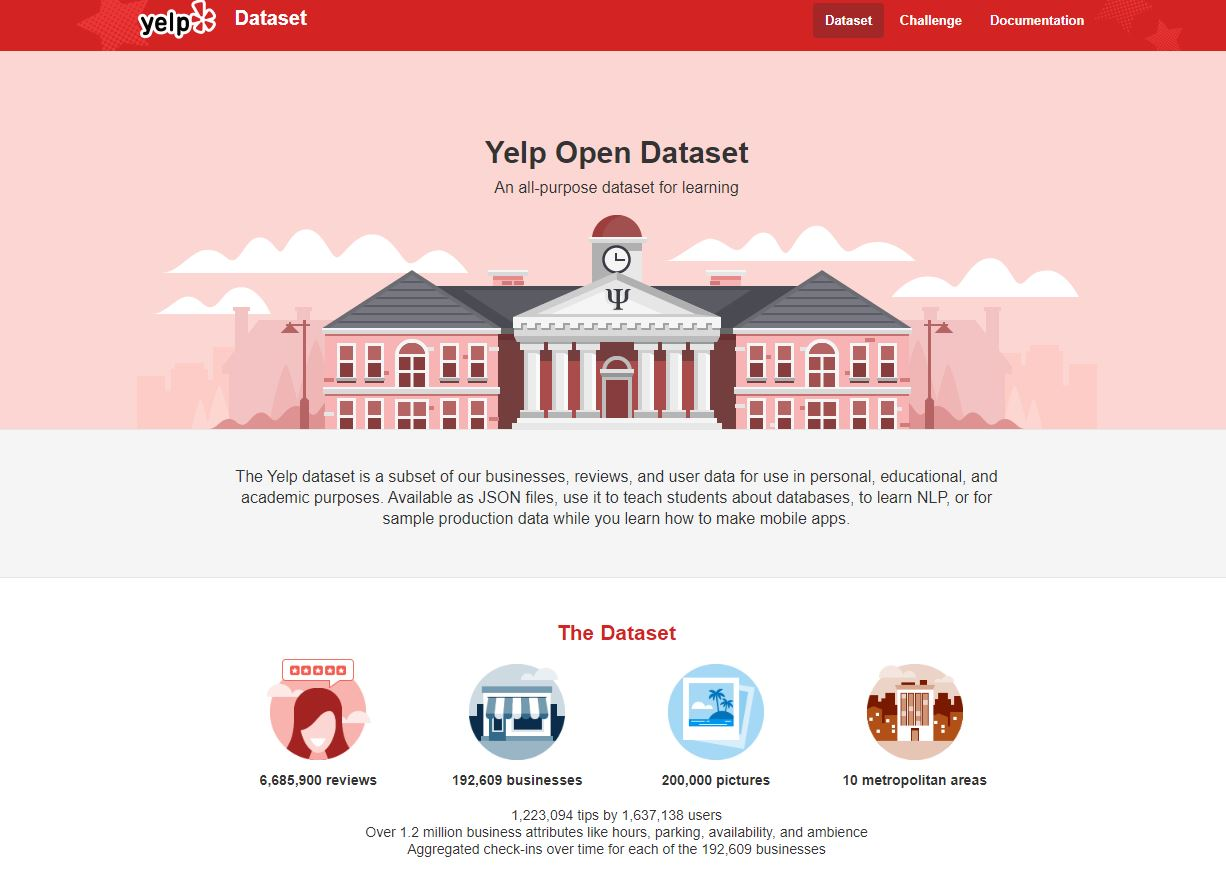

In [2]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sklearn.metrics as metrics

%matplotlib inline

In [3]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Data Preparation:

In [4]:
#assign file paths
business_json_path = 'C:/Users/aakan/Documents/yelp_dataset/business.json'
photo_json_path = 'C:/Users/aakan/Documents/yelp_dataset/photo.json'

#### Business Data:

In [5]:
# read business df
business = pd.read_json(business_json_path, lines=True)

In [4]:
business.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [6]:
# drop irrelevant columns - address, postal code, latitude, longitude that I will not use due to high cardinality
drop_list = ["address", "postal_code","latitude","longitude", "hours"]
df_bus = business.drop(drop_list, axis=1)

In [7]:
df_bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 9 columns):
business_id     192609 non-null object
name            192609 non-null object
city            192609 non-null object
state           192609 non-null object
stars           192609 non-null float64
review_count    192609 non-null int64
is_open         192609 non-null int64
attributes      163773 non-null object
categories      192127 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 13.2+ MB


Categories and attributes have missing values

In [5]:
# check % of open businesses
# 1 = open, 0 = closed
print("Open Businesses:",round(len(df_bus[df_bus.is_open == 1])/len(df_bus) * 100,2),"%")

Open Businesses: 82.3 %


In [7]:
# I have removed the closed businesses for this analysis

business_open = df_bus[df_bus.is_open == 1]
business_open = business_open.drop('is_open', axis=1)

In [9]:
business_open.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158525 entries, 1 to 192607
Data columns (total 10 columns):
business_id     158525 non-null object
name            158525 non-null object
city            158525 non-null object
state           158525 non-null object
latitude        158525 non-null float64
longitude       158525 non-null float64
stars           158525 non-null float64
review_count    158525 non-null int64
attributes      132752 non-null object
categories      158064 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 13.3+ MB


There are 158,525 open businesses.

## Data Munging:

In [8]:
# Replacing missing categories with Unknown
business_open['categories'].fillna('Unknown',inplace=True)

## EDA: 

#### Univariate Analysis

In [8]:
business_open.describe()

,stars,review_count
count,158525.000000,158525.000000
mean,3.609787,35.495657
std,1.038052,116.597820
min,1.000000,3.000000
25%,3.000000,4.000000
50%,3.500000,9.000000
75%,4.500000,26.000000
max,5.000000,8348.000000


###### Stars distribution

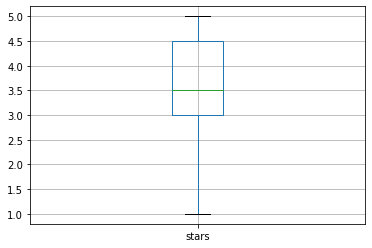

In [13]:
# boxplot
business_open.boxplot(column='stars')

Stars is negatively skewed - could be due to variation in categories, location etc. 25% businesses are rated less than 3 stars.

In [255]:
business_open.review_count.sum()

5626949

158,525 businesses have received 5,626,949 reviews.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A5D7E1DB88>,
      dtype=object)

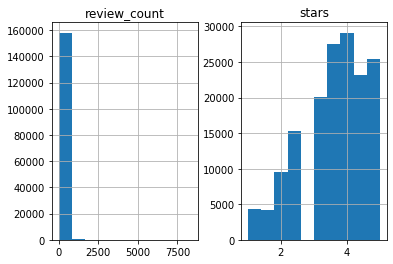

In [9]:
business_open.hist()

In [17]:
# checking 99th percentile for reviews
business_open.review_count.quantile(0.99)

428.0

In [12]:
# Skewness & Kurtosis
from scipy.stats import kurtosis
print('Skewness in Reviews and Stars:',business_open["review_count"].skew(),',',business_open["stars"].skew())
print('Kurtosis in Reviews and Stars:',kurtosis(business_open.review_count),',',kurtosis(business_open.stars))

Skewness in Reviews and Stars: 18.593658644088293 , -0.5284468352552144
Kurtosis in Reviews and Stars: 701.6985679427315 , -0.3874547660542764


#### Summary 
##### Stars -
Median star rating = 3.5. 50% of open businesses have less than 3.5 stars. <br>
Only 25% of open businesses get the high star rating between 4.5 and 5. <br>

##### Reviews - 
On average, there are 35.5 reviews per open business. Median reviews = 9. These open businesses have received at least 3 reviews.<br>
There is very high variablity in number of reviews as standard deviation = 116.6. <br>
Maximum number of reviews received by an open business is a whopping 8,348. 75% of businesses have less than 26 reviews. The high kurtosis value indicates presence of outliers.

#### Visualization

(-1.116455036428145, 1.109944623239243, -1.113289671831327, 1.1006328415157776)

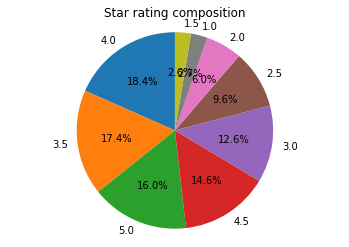

In [28]:
# Pie chart for star rating distribution
plt.pie(
   business_open['stars'].value_counts().values, # plot the value counts
    labels= business_open['stars'].value_counts().index, # add the labels
    startangle=90, # make it easier to read by starting at 90degree angle
    autopct='%1.1f%%', # label percent
    )
plt.title("Star rating composition")
# View the plot drop above
plt.axis('equal')

#### Bivariate analysis

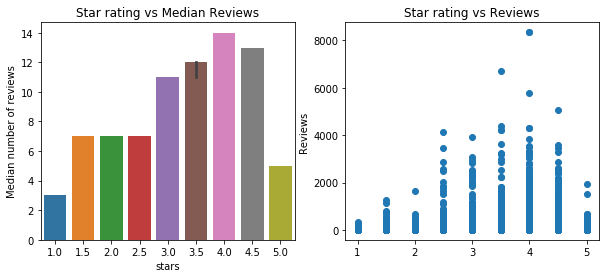

In [8]:
# Stars and reviews
fig = plt.figure(figsize=(10,4))


# Barplot of stars vs number of reviews
ax1 = plt.subplot2grid((1,2),(0,0))
ax1 = sns.barplot(x="stars", y="review_count", data=business_open,estimator=np.median)
plt.ylabel("Median number of reviews")
plt.title("Star rating vs Median Reviews")

# Scatterplot of Star rating vs reviews
ax1 = plt.subplot2grid((1,2),(0,1))
plt.scatter('stars','review_count',data=business_open)
plt.ylabel("Reviews")
plt.title("Star rating vs Reviews")



# View the plot
plt.show()

On average, frequency of reviews are highest for businesses rated as 4 and 4.5.<br>
Also, 30% of businesses are rated either 3 or 3.5. <br> 
Around 50% of businesses are rated as greater than equal to 4 stars which may be due to higher number of reviews received.

In [112]:
business_open['stars'].corr(business_open['review_count'])

0.04059536560567431

Thus reviews and star rating have no correlation. There are  businesses having rating 3.5 and 4 with outlier reviews of more than 6000 which changes the relationship between reviews and stars.

In [71]:
#Top 20 most reviewed businesses
business_open[['name', 'review_count', 'city', 'stars','categories']].sort_values(ascending=False, by="review_count")[:20]

,name,review_count,city,stars,categories
82250,Mon Ami Gabi,8348,Las Vegas,4.0,"Food, French, Breakfast & Brunch, Restaurants,..."
89206,Bacchanal Buffet,8339,Las Vegas,4.0,"Restaurants, Buffets, Sandwiches, Food, Breakf..."
35199,Wicked Spoon,6708,Las Vegas,3.5,"Buffets, Breakfast & Brunch, Restaurants"
58852,Hash House A Go Go,5763,Las Vegas,4.0,"Breakfast & Brunch, Food, Restaurants, America..."
83950,Earl of Sandwich,5075,Las Vegas,4.5,"Food Delivery Services, Salad, Sandwiches, Sou..."
174616,The Buffet,4400,Las Vegas,3.5,"Beauty & Spas, Food, Event Planning & Services..."
89437,The Cosmopolitan of Las Vegas,4322,Las Vegas,4.0,"Casinos, Hotels, Event Planning & Services, Re..."
29614,Secret Pizza,4286,Las Vegas,4.0,"Pizza, Restaurants"
1975,The Buffet at Bellagio,4227,Las Vegas,3.5,"American (New), Buffets, Restaurants"
170982,ARIA Resort & Casino,4206,Las Vegas,3.5,"Hotels & Travel, Arts & Entertainment, Hotels,..."


Mon Ami Gabi which is a French restaurant in Las Vegas, NV has the highest number of reviews of 8,348. <br>
The top 20 reviewed businesses are in Las Vegas are also highly rated; the top 10 are in fact above 3.5. Las Vegas strip is home to multiple high quality restaurants, mostly to attract tourists and locals in the Casinos. 

As reviews shows variablity and is high for restaurants, filtering data to only study the highest reviewed category - restaurants.

#### Data Munging

In [9]:
# Filter for restaurant category
rest=business_open[business_open['categories'].str.contains("Restaurants")]
rest.head()

,business_id,name,city,state,stars,review_count,attributes,categories
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese"
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,3.0,18,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Restaurants, Breakfast & Brunch, Mexican, Taco..."
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,4.0,16,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Italian, Restaurants, Pizza, Chicken Wings"
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,PA,4.0,35,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo..."


In [23]:
#Data size
print('Number of businesses categorized as Restaurants:',len(rest))

Number of businesses categorized as Restaurants: 42237


In [10]:
#Split attributes column

res_attr=pd.concat([rest.drop(['attributes'], axis=1), rest['attributes'].apply(pd.Series)], axis=1)

In [16]:
res_attr.head(5)

,business_id,name,city,state,latitude,longitude,stars,review_count,categories,RestaurantsReservations,...,BYOBCorkage,Corkage,BYOB,ByAppointmentOnly,AgesAllowed,AcceptsInsurance,DietaryRestrictions,HairSpecializesIn,Open24Hours,RestaurantsCounterService
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,43.605499,-79.652289,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,35.092564,-80.859132,4.0,170,"Sushi Bars, Restaurants, Japanese",True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,33.495194,-112.028588,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,41.708520,-81.359556,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,PA,40.496177,-80.246011,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Calculate the percent of missing data  in each column
res_attr.isnull().sum()/len(res_attr)*100
# Currently there are 39 attributes

business_id                    0.000000
name                           0.000000
city                           0.000000
state                          0.000000
stars                          0.000000
review_count                   0.000000
categories                     0.000000
RestaurantsReservations       13.537893
GoodForMeal                   39.148140
BusinessParking               20.361295
Caters                        37.171201
NoiseLevel                    30.639013
RestaurantsTableService       66.754268
RestaurantsTakeOut            10.649431
RestaurantsPriceRange2        13.215901
OutdoorSeating                19.587092
BikeParking                   26.010370
Ambience                      21.687146
HasTV                         22.231693
WiFi                          27.348060
GoodForKids                   14.442314
Alcohol                       25.870682
RestaurantsAttire             19.669958
RestaurantsGoodForGroups      14.245803
RestaurantsDelivery           14.335772


A lot of attributes have missing values which need to be treated.

In [11]:
#Remove attributes with missing values. As industry standard is to have less than 40% missing data, I have removed these attributes
threshold = 0.4
res_attr1 = res_attr[res_attr.columns[res_attr.isnull().mean() < threshold]]

res_attr1.head()

,business_id,name,city,state,stars,review_count,categories,RestaurantsReservations,GoodForMeal,BusinessParking,...,OutdoorSeating,BikeParking,Ambience,HasTV,WiFi,GoodForKids,Alcohol,RestaurantsAttire,RestaurantsGoodForGroups,RestaurantsDelivery
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",...,False,False,"{'romantic': False, 'intimate': False, 'classy...",False,u'no',True,u'full_bar',u'casual',True,False
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese",True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",...,False,True,"{'romantic': False, 'intimate': False, 'touris...",True,u'no',True,u'beer_and_wine','casual',True,False
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",False,NaN,"{'garage': False, 'street': False, 'validated'...",...,False,NaN,"{'romantic': False, 'intimate': False, 'touris...",False,u'no',True,u'none',u'casual',True,False
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",False,NaN,None,...,False,True,None,NaN,NaN,True,u'none',u'casual',True,True
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,PA,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",False,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",...,False,NaN,"{'touristy': False, 'hipster': False, 'romanti...",False,NaN,True,NaN,NaN,True,False


In [26]:
#Number of business attributes remaining
print('Restaurant attributes remaining in data:',len(res_attr1.columns[7:]))


Restaurant attributes remaining in data: 17


In [12]:
#Dropping restaurants with missing value rate higher than threshold = 40%
res_attr2 = res_attr1.loc[res_attr1.isnull().mean(axis=1) < threshold]

In [28]:
#Businesses remaining in data
print('Restaurants remaining out of 42,237 restaurants:',len(res_attr2))

Restaurants remaining out of 42,237 restaurants: 35105


In [115]:
#checking missing % again
res_attr2.isnull().sum()/len(res_attr2)*100

# The missing values have reduced significantly

business_id                  0.000000
name                         0.000000
city                         0.000000
state                        0.000000
stars                        0.000000
review_count                 0.000000
categories                   0.000000
starscat                     0.000000
RestaurantsReservations      2.210511
GoodForMeal                 29.075630
BusinessParking              9.930209
Caters                      26.719840
NoiseLevel                  17.404928
RestaurantsTakeOut           1.535394
RestaurantsPriceRange2       1.925652
OutdoorSeating               5.563310
BikeParking                 14.311352
Ambience                     7.688363
HasTV                        7.329440
WiFi                        14.972226
GoodForKids                  3.022361
Alcohol                     12.066657
RestaurantsAttire            5.406637
RestaurantsGoodForGroups     2.444096
RestaurantsDelivery          3.218915
dtype: float64

3 Attrbutes still contain dictionary values - GoodForMeal, BusinessParking, Ambience

In [13]:
# Replacing missing values with 0 denoting absence
res_attr2.fillna('0',axis=1)

,business_id,name,city,state,stars,review_count,categories,RestaurantsReservations,GoodForMeal,BusinessParking,...,OutdoorSeating,BikeParking,Ambience,HasTV,WiFi,GoodForKids,Alcohol,RestaurantsAttire,RestaurantsGoodForGroups,RestaurantsDelivery
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",...,False,False,"{'romantic': False, 'intimate': False, 'classy...",False,u'no',True,u'full_bar',u'casual',True,False
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese",True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",...,False,True,"{'romantic': False, 'intimate': False, 'touris...",True,u'no',True,u'beer_and_wine','casual',True,False
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",False,0,"{'garage': False, 'street': False, 'validated'...",...,False,0,"{'romantic': False, 'intimate': False, 'touris...",False,u'no',True,u'none',u'casual',True,False
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",False,0,None,...,False,True,None,0,0,True,u'none',u'casual',True,True
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,PA,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",False,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",...,False,0,"{'touristy': False, 'hipster': False, 'romanti...",False,0,True,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192585,3HAPJH0Qoi8Ix6M9rUMfjg,Indian Hero,Brampton,ON,3.0,39,"Restaurants, Indian",True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",...,False,True,"{'romantic': False, 'intimate': False, 'classy...",False,'free',True,u'none',u'casual',True,True
192587,oS0CnUbyv0GUoD3L8_3UPQ,Thai Fantasy,Toronto,ON,4.0,113,"Restaurants, Thai",True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': True, 'validated':...",...,False,True,"{'touristy': False, 'hipster': False, 'romanti...",False,u'free',True,u'beer_and_wine',u'casual',True,True
192589,ghovD5ZTGDQ5Q2U4ERddWw,Five Guys,Fairlawn,OH,4.0,22,"Burgers, Restaurants, Fast Food, American (New)",False,0,"{'garage': False, 'street': False, 'validated'...",...,False,False,"{'romantic': False, 'intimate': False, 'classy...",False,'no',True,u'none',u'casual',True,False
192596,KnafX7T6qSAmSrLhd709vA,Pho Maisonneuve,MontrÃ©al,QC,4.0,25,"Vietnamese, Soup, Restaurants",True,0,None,...,False,False,"{'romantic': False, 'intimate': False, 'classy...",True,u'no',True,u'full_bar',u'casual',True,True


##### Treating GoodForMeal

In [14]:
# Splitting GoodForMeal and renaming columns
meal=res_attr2['GoodForMeal'].str.split(',').apply(pd.Series)
meal.columns = ["GoodForDessert", "GoodForLatenight", "GoodForLunch", "GoodForDinner","GoodForBrunch","GoodForBreakfast"]

meal.head()

,GoodForDessert,GoodForLatenight,GoodForLunch,GoodForDinner,GoodForBrunch,GoodForBreakfast
1,{'dessert': False,'latenight': False,'lunch': True,'dinner': True,'brunch': False,'breakfast': False}
2,{'dessert': False,'latenight': False,'lunch': True,'dinner': True,'brunch': False,'breakfast': False}
11,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN
23,{'dessert': False,'latenight': False,'lunch': False,'dinner': False,'brunch': False,'breakfast': False}


In [181]:
# checking if dictionaries split correctly
meal.GoodForBreakfast.value_counts()

 'breakfast': False}    21597
 'breakfast': True}      3090
 'brunch': False}          43
Name: GoodForBreakfast, dtype: int64

In [182]:
meal.GoodForBrunch.value_counts()

 'brunch': False       21533
 'brunch': True         3154
 'breakfast': False       42
 'breakfast': True         1
Name: GoodForBrunch, dtype: int64

As GoodForBrunch and GoodForBreakfast have interchaged values for 43 restaurants, reverse the values

In [15]:
# Replacing missing values with 0 denoting absence of meal type
meal.fillna('0',inplace=True)

In [16]:
# moving GoodForBrunch values from GoodForBreakfast and vice versa for the 43 restaurants

meal['GoodForBreakfast'].loc[meal['GoodForBrunch'].str.contains("'breakfast': True")]='1'
meal['GoodForBrunch'].loc[meal['GoodForBrunch'].str.contains("'breakfast': True")]='0'
meal['GoodForBrunch'].loc[meal['GoodForBrunch'].str.contains("'breakfast': False")]='0'

In [33]:
meal.GoodForBrunch.value_counts()

 'brunch': False    21533
0                   10418
 'brunch': True      3154
Name: GoodForBrunch, dtype: int64

In [17]:
# replacing False with 0 and True with 1
for cl in meal.columns:
    meal[cl].loc[meal[cl].str.contains('False')]='0'
    meal[cl].loc[meal[cl].str.contains('True')]='1'

meal.head()

,GoodForDessert,GoodForLatenight,GoodForLunch,GoodForDinner,GoodForBrunch,GoodForBreakfast
1,0,0,1,1,0,0
2,0,0,1,1,0,0
11,0,0,0,0,0,0
13,0,0,0,0,0,0
23,0,0,0,0,0,0


##### Treating BusinessParking

In [18]:
# Splitting BusinessParking and renaming columns
park=res_attr2['BusinessParking'].str.split(',').apply(pd.Series)
park.columns = ["ParkingGarage", "ParkingStreet", "ParkingValidated", "ParkingLot","ParkingValet"]

park.head()

,ParkingGarage,ParkingStreet,ParkingValidated,ParkingLot,ParkingValet
1,{'garage': False,'street': False,'validated': False,'lot': True,'valet': False}
2,{'garage': False,'street': False,'validated': False,'lot': True,'valet': False}
11,{'garage': False,'street': False,'validated': False,'lot': False,'valet': False}
13,None,NaN,NaN,NaN,NaN
23,{'garage': False,'street': False,'validated': False,'lot': False,'valet': False}


In [606]:
# checking if dictionaries split correctly
park.ParkingGarage.value_counts()

{'garage': False     29384
0                     3486
{'garage': True       1581
None                   631
{'valet': False         20
{'garage': False}        2
{}                       1
Name: ParkingGarage, dtype: int64

In [607]:
park.ParkingValet.value_counts()

 'valet': False}        30152
 'valet': True}           812
 'validated': False}       20
Name: ParkingValet, dtype: int64

In [375]:
park.ParkingValidated.value_counts()

 'validated': False    30741
 'validated': True       221
 'street': False          20
 'street': True            2
 'lot': False              1
Name: ParkingValidated, dtype: int64

In [376]:
park.ParkingStreet.value_counts()

 'street': False       24232
 'street': True         6731
 'garage': False          20
 'validated': False        2
Name: ParkingStreet, dtype: int64

In [36]:
park.ParkingLot.value_counts()

 'lot': False       17291
 'lot': True        13693
 'valet': False}        1
Name: ParkingLot, dtype: int64

In [19]:
# Replacing missing values with 0 denoting absence of parking type
park.fillna('0',inplace=True)

In [20]:
# Creating temp columns to store values for swapping
park['valet']=""
park['validated']=""
park['street']=""
park['garage']=""

park['valet'].loc[park['ParkingGarage'].str.contains("'valet': False")]='0'
park['valet'].loc[park['ParkingLot'].str.contains("'valet': False")]='0'
park['valet'].loc[park['ParkingLot'].str.contains("'valet': False")]='0'

park['validated'].loc[park['ParkingValet'].str.contains("'validated': False")]='0'
park['validated'].loc[park['ParkingStreet'].str.contains("'validated': False")]='0'

park['street'].loc[park['ParkingValidated'].str.contains("'street': False")]='0'
park['street'].loc[park['ParkingValidated'].str.contains("'street': True")]='1'
park['ParkingLot'].loc[park['ParkingValidated'].str.contains("'lot': False")]='0'

park['garage'].loc[park['ParkingStreet'].str.contains("'garage': False")]='0'



# Replacing park values
park['ParkingLot'].loc[park['ParkingLot'].str.contains("'valet")]='0'
park['ParkingStreet'].loc[park['street'].str.contains("0")]='0'
park['ParkingStreet'].loc[park['street'].str.contains("1")]='1'
park['ParkingGarage'].loc[park['garage'].str.contains("0")]='0'
park['ParkingValidated'].loc[park['validated'].str.contains("0")]='0'
park['ParkingValidated'].loc[park['ParkingValidated'].str.contains("lot")]='0'
park['ParkingValet'].loc[park['valet'].str.contains("0")]='0'

park['ParkingGarage'].loc[park['ParkingGarage'].str.contains("{}")]='0'

In [21]:
#Dropping temp columns
park.drop(['valet','validated','street','garage'],axis=1,inplace=True)

park.head()

,ParkingGarage,ParkingStreet,ParkingValidated,ParkingLot,ParkingValet
1,{'garage': False,'street': False,'validated': False,'lot': True,'valet': False}
2,{'garage': False,'street': False,'validated': False,'lot': True,'valet': False}
11,{'garage': False,'street': False,'validated': False,'lot': False,'valet': False}
13,None,0,0,0,0
23,{'garage': False,'street': False,'validated': False,'lot': False,'valet': False}


In [22]:
# replacing False with 0 and True with 1
for cl in park.columns:
    park[cl].loc[park[cl].str.contains('False|None')]='0'
    park[cl].loc[park[cl].str.contains('True')]='1'

park.head()

,ParkingGarage,ParkingStreet,ParkingValidated,ParkingLot,ParkingValet
1,0,0,0,1,0
2,0,0,0,1,0
11,0,0,0,0,0
13,0,0,0,0,0
23,0,0,0,0,0


In [23]:
#checking blank dictionary is removed
park.ParkingGarage.value_counts()

0    33524
1     1581
Name: ParkingGarage, dtype: int64

In [23]:
#Merging Meal and parking back to restaurants and dropping Ambience as it has high cardinality
res_attr3=pd.concat([res_attr2.drop(['GoodForMeal','BusinessParking','Ambience'],axis=1), meal,park], axis=1)
res_attr3.head()

,business_id,name,city,state,stars,review_count,categories,RestaurantsReservations,Caters,NoiseLevel,...,GoodForLatenight,GoodForLunch,GoodForDinner,GoodForBrunch,GoodForBreakfast,ParkingGarage,ParkingStreet,ParkingValidated,ParkingLot,ParkingValet
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",True,True,u'loud',...,0,1,1,0,0,0,0,0,1,0
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese",True,False,u'average',...,0,1,1,0,0,0,0,0,1,0
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",False,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",False,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,PA,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",False,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#Impute missing values - As attribute's presence/absence is unknown and cannot be imputed, I converted to 0
res_attr3.fillna('0',axis=1,inplace=True)
res_attr3.head(5)

,business_id,name,city,state,stars,review_count,categories,RestaurantsReservations,Caters,NoiseLevel,...,GoodForLatenight,GoodForLunch,GoodForDinner,GoodForBrunch,GoodForBreakfast,ParkingGarage,ParkingStreet,ParkingValidated,ParkingLot,ParkingValet
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",True,True,u'loud',...,0,1,1,0,0,0,0,0,1,0
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese",True,False,u'average',...,0,1,1,0,0,0,0,0,1,0
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",False,0,0,...,0,0,0,0,0,0,0,0,0,0
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",False,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,PA,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",False,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Treating Ambience


In [518]:
# Splitting Ambience and renaming columns
amb=res_attr2['Ambience'].str.split(',').apply(pd.Series)
amb.head()

,0,1,2,3,4,5,6,7,8
1,{'romantic': False,'intimate': False,'classy': False,'hipster': False,'divey': False,'touristy': False,'trendy': False,'upscale': False,'casual': True}
2,{'romantic': False,'intimate': False,'touristy': False,'hipster': False,'divey': False,'classy': False,'trendy': False,'upscale': False,'casual': True}
11,{'romantic': False,'intimate': False,'touristy': False,'hipster': False,'divey': False,'classy': False,'trendy': False,'upscale': False,'casual': False}
13,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,{'touristy': False,'hipster': False,'romantic': False,'divey': False,'intimate': False,'trendy': False,'upscale': False,'classy': False,'casual': False}


In [418]:
#counts
amb.AmbienceTouristy.value_counts() 

 'touristy': False    14277
 'trendy': False       6920
 'classy': False       5113
 'upscale': False      4476
 'trendy': True         978
 'upscale': True         76
 'classy': True          72
 'touristy': True        38
 'casual': False}         8
 'casual': True}          8
 'hipster': False         1
Name: AmbienceTouristy, dtype: int64

As Ambience has 9*2 = 18 levels which seem related like trendy and classy, have dropped Ambience to avoid increasing data dimensionality.

#### Treating Attributes

In [25]:
# Convert True and False to 1 and 0 respectively in the attributes
true=res_attr3.replace("True",'1')
false=true.replace("False",'0')
false.head()

,business_id,name,city,state,stars,review_count,categories,RestaurantsReservations,Caters,NoiseLevel,...,GoodForLatenight,GoodForLunch,GoodForDinner,GoodForBrunch,GoodForBreakfast,ParkingGarage,ParkingStreet,ParkingValidated,ParkingLot,ParkingValet
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",1,1,u'loud',...,0,1,1,0,0,0,0,0,1,0
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese",1,0,u'average',...,0,1,1,0,0,0,0,0,1,0
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,PA,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Treating NoiseLevel

In [64]:
false.NoiseLevel.value_counts()

u'average'      15359
0                6110
u'quiet'         4662
'average'        4448
u'loud'          2101
'quiet'          1139
u'very_loud'      730
'loud'            412
'very_loud'        97
None               47
Name: NoiseLevel, dtype: int64

In [27]:
# Converting noise levels to ordinal features
# 1 and missing for quiet
# 2 for average
# 3 for loud
# 4 for very loud
false['NoiseLevel'].loc[false['NoiseLevel'].str.contains('None|0')]='1'
false['NoiseLevel'].loc[false['NoiseLevel'].str.contains('quiet')]='2'
false['NoiseLevel'].loc[false['NoiseLevel'].str.contains('average')]='3'
false['NoiseLevel'].loc[false['NoiseLevel'].str.contains('very_loud')]='v'
false['NoiseLevel'].loc[false['NoiseLevel'].str.contains('loud')]='4'

In [28]:
# Changing very loud to category 4
false['NoiseLevel'].loc[false['NoiseLevel'].str.contains('v')]='5'
false['NoiseLevel'].value_counts()

3    19807
1     6157
2     5801
4     2513
5      827
Name: NoiseLevel, dtype: int64

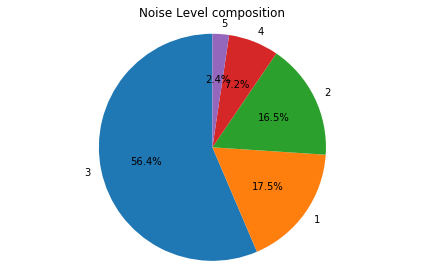

In [67]:
# Pie chart for noise level distribution
plt.pie(
   false['NoiseLevel'].value_counts().values, # plot the value counts
    labels= false['NoiseLevel'].value_counts().index, # add the labels
    startangle=90, # make it easier to read by starting at 90degree angle
    autopct='%1.1f%%', # label percent
    )
plt.title("Noise Level composition")
# View the plot drop above
plt.axis('equal')
plt.tight_layout()

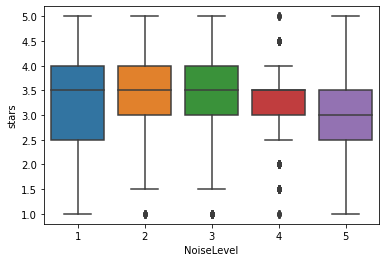

In [81]:
# Does noise level impact stars?
sns.boxplot(x='NoiseLevel', y='stars', data=false)

Quiet and average noisy restaurants have identical stars distribution. 

#### Treating Restaurant price range

In [259]:
false.RestaurantsPriceRange2.value_counts()

2       18151
1       14374
3        1588
0         676
4         290
None       26
Name: RestaurantsPriceRange2, dtype: int64

In [29]:
# Assuming missing price and no price has price range 1 and shifting the price ranges up by 1
false['RestaurantsPriceRange2'].loc[false['RestaurantsPriceRange2'].str.contains('0|None')]='m'
false['RestaurantsPriceRange2'].loc[false['RestaurantsPriceRange2'].str.contains('1')]='o'
false['RestaurantsPriceRange2'].loc[false['RestaurantsPriceRange2'].str.contains('2')]='t'
false['RestaurantsPriceRange2'].loc[false['RestaurantsPriceRange2'].str.contains('3')]='h'
false['RestaurantsPriceRange2'].loc[false['RestaurantsPriceRange2'].str.contains('4')]='f'


In [30]:
# recoding price
false['RestaurantsPriceRange2'].loc[false['RestaurantsPriceRange2'].str.contains('m')]='1'
false['RestaurantsPriceRange2'].loc[false['RestaurantsPriceRange2'].str.contains('o')]='2'
false['RestaurantsPriceRange2'].loc[false['RestaurantsPriceRange2'].str.contains('t')]='3'
false['RestaurantsPriceRange2'].loc[false['RestaurantsPriceRange2'].str.contains('h')]='4'
false['RestaurantsPriceRange2'].loc[false['RestaurantsPriceRange2'].str.contains('f')]='5'

false.RestaurantsPriceRange2.value_counts()

3    18151
2    14374
4     1588
1      702
5      290
Name: RestaurantsPriceRange2, dtype: int64

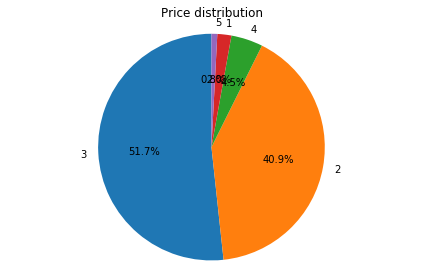

In [60]:
# Pie chart for Restaurant price range
plt.pie(
   false['RestaurantsPriceRange2'].value_counts().values, # plot the value counts
    labels= false['RestaurantsPriceRange2'].value_counts().index, # add the labels
    startangle=90, # make it easier to read by starting at 90degree angle
    autopct='%1.1f%%', # label percent
    )

# View the plot drop above
plt.axis('equal')

# View the plot
plt.title("Price distribution")
plt.tight_layout()


52% of restaurants are priced as range 2 or $$, while 41% of restaurants are priced as $ or range 1.

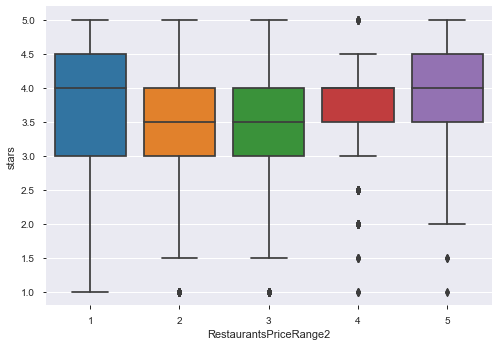

In [217]:
# Do expensive restaurants get more stars?
sns.boxplot(x='RestaurantsPriceRange2', y='stars', data=false)

Outlier restaurants are there in all given price ranges. <br> 50% of restaurants with no given price range (1) have star rating between 3 and 4.5 as majority of restaurants fall in this star rating. <br>There is no variation in restaurants in price ranges 1 and 2. Most expensive restaurants have the high median star rating of 4.

#### Treating WiFi

In [66]:
false.WiFi.value_counts()

u'no'      9189
u'free'    8732
'no'       6165
'free'     5458
0          5256
u'paid'     127
'paid'      101
None         77
Name: WiFi, dtype: int64

In [31]:
# Converting WiFi to ordinal levels
# 1 for missing and No WiFi
# 2 for paid WiFi
# 3 for free WiFi

false['WiFi'].loc[false['WiFi'].str.contains('no|None|0')]='No'
false['WiFi'].loc[false['WiFi'].str.contains('paid')]='Paid'
false['WiFi'].loc[false['WiFi'].str.contains('free')]='Free'
false['WiFi'].value_counts()

No      20687
Free    14190
Paid      228
Name: WiFi, dtype: int64

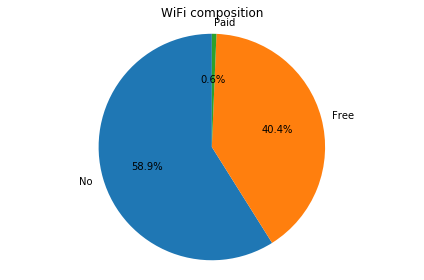

In [82]:
# Pie chart for wifi distribution
plt.pie(
   false['WiFi'].value_counts().values, # plot the value counts
    labels= false['WiFi'].value_counts().index, # add the labels
    startangle=90, # make it easier to read by starting at 90degree angle
    autopct='%1.1f%%', # label percent
    )
plt.title("WiFi composition")
# View the plot drop above
plt.axis('equal')
plt.tight_layout()

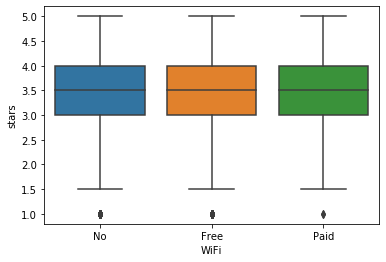

In [62]:
# Does WiFi impact stars?
sns.boxplot(x='WiFi', y='stars', data=false)

WiFi status doesn't change with the star ratings. However, there are outlier 1 star businesses

In [32]:
wifi=pd.get_dummies(false['WiFi']).add_prefix('WiFi_')
wifi.head()

,WiFi_Free,WiFi_No,WiFi_Paid
1,0,1,0
2,0,1,0
11,0,1,0
13,0,1,0
23,0,1,0


In [33]:
# As dummies have n-1 categories, dropping wifi no as WiFi Free 0 and WiFi Paid 0 means WiFi no is 1 else 0
wifi.drop('WiFi_No',axis=1,inplace=True)
wifi.head()

,WiFi_Free,WiFi_Paid
1,0,0
2,0,0
11,0,0
13,0,0
23,0,0


#### Treating Alcohol

In [70]:
false.Alcohol.value_counts()

u'none'             10852
u'full_bar'          9128
'none'               4486
0                    4236
u'beer_and_wine'     2987
'full_bar'           2031
'beer_and_wine'      1338
None                   47
Name: Alcohol, dtype: int64

In [34]:
# # Converting Alcohol to ordinal levels
false['Alcohol'].loc[false['Alcohol'].str.contains('no|None|0')]='No'
false['Alcohol'].loc[false['Alcohol'].str.contains('full_bar')]='Full_Bar'
false['Alcohol'].loc[false['Alcohol'].str.contains('beer_and_wine')]='Beer_Wine'
false['Alcohol'].value_counts()

No           19621
Full_Bar     11159
Beer_Wine     4325
Name: Alcohol, dtype: int64

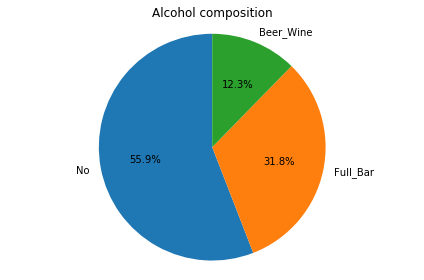

In [83]:
# Pie chart for alcohol distribution
plt.pie(
   false['Alcohol'].value_counts().values, # plot the value counts
    labels= false['Alcohol'].value_counts().index, # add the labels
    startangle=90, # make it easier to read by starting at 90degree angle
    autopct='%1.1f%%', # label percent
    )
plt.title("Alcohol composition")
# View the plot drop above
plt.axis('equal')
plt.tight_layout()

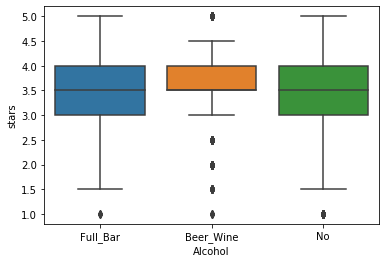

In [68]:
# Does Alcoholimpact star ratings?
sns.boxplot(x='Alcohol', y='stars', data=false)

50% of businesses serving Beer and Wine are rated 3.5 or 4 stars. But beer and wine category has lot of low star rated outlier businesses also.

In [35]:
alc=pd.get_dummies(false['Alcohol']).add_prefix('Alcohol_')

In [36]:
# As dummies have n-1 categories, dropping alcohol no
alc.drop('Alcohol_No',axis=1,inplace=True)
alc.head()

,Alcohol_Beer_Wine,Alcohol_Full_Bar
1,0,1
2,1,0
11,0,0
13,0,0
23,0,0


#### Treating RestaurantsAttire

In [74]:
false['RestaurantsAttire'].value_counts()

u'casual'    18258
'casual'     14020
0             1898
u'dressy'      532
'dressy'       290
u'formal'       39
'formal'        38
None            30
Name: RestaurantsAttire, dtype: int64

In [37]:
# Converting RestaurantsAttire  to groupings
false['RestaurantsAttire'].loc[false['RestaurantsAttire'].str.contains('casual')]='Casual'
false['RestaurantsAttire'].loc[false['RestaurantsAttire'].str.contains('None|0')]='No'
false['RestaurantsAttire'].loc[false['RestaurantsAttire'].str.contains('dressy')]='Dressy'
false['RestaurantsAttire'].loc[false['RestaurantsAttire'].str.contains('formal')]='Formal'
false['RestaurantsAttire'].value_counts()

Casual    32278
No         1928
Dressy      822
Formal       77
Name: RestaurantsAttire, dtype: int64

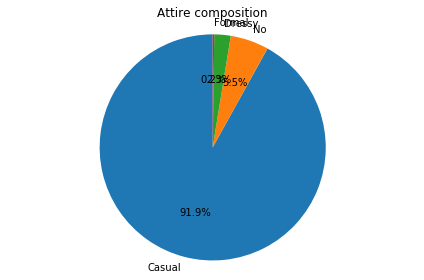

In [86]:
# Pie chart for attire distribution
plt.pie(
   false['RestaurantsAttire'].value_counts().values, # plot the value counts
    labels= false['RestaurantsAttire'].value_counts().index, # add the labels
    startangle=90, # make it easier to read by starting at 90degree angle
    autopct='%1.1f%%', # label percent
    )
plt.title("Attire composition")
# View the plot drop above
plt.axis('equal')
plt.tight_layout()

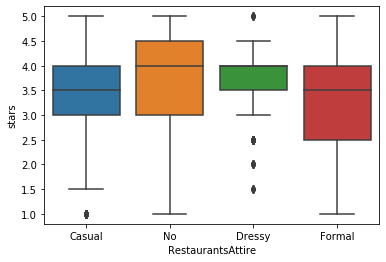

In [73]:
# Does attire impact stars?
sns.boxplot(x='RestaurantsAttire', y='stars', data=false)

50% of businesses having Dressy dress code are rated 3.5 and 4. However, there are outlier businesses too having this dress code. Surprisingly, businesses having no dress code have the highest median star rating of 4. This implies 50% of no dress code businesses have more than 4 star rating.

In [38]:
att=pd.get_dummies(false['RestaurantsAttire']).add_prefix('Attire_')
att.head()

,Attire_Casual,Attire_Dressy,Attire_Formal,Attire_No
1,1,0,0,0
2,1,0,0,0
11,1,0,0,0
13,1,0,0,0
23,0,0,0,1


In [39]:
# As dummies have n-1 categories, dropping attire no
att.drop('Attire_No',axis=1,inplace=True)  
att.head()

,Attire_Casual,Attire_Dressy,Attire_Formal
1,1,0,0
2,1,0,0
11,1,0,0
13,1,0,0
23,0,0,0


In [40]:
# Merging all attributes back to restaurants data
resdf=pd.concat([false.drop(['WiFi','Alcohol','RestaurantsAttire'],axis=1),wifi,alc,att], axis=1)
resdf.head()

,business_id,name,city,state,stars,review_count,categories,RestaurantsReservations,Caters,NoiseLevel,...,ParkingValidated,ParkingLot,ParkingValet,WiFi_Free,WiFi_Paid,Alcohol_Beer_Wine,Alcohol_Full_Bar,Attire_Casual,Attire_Dressy,Attire_Formal
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",1,1,4,...,0,1,0,0,0,0,1,1,0,0
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese",1,0,3,...,0,1,0,0,0,1,0,1,0,0
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",0,0,1,...,0,0,0,0,0,0,0,1,0,0
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",0,0,1,...,0,0,0,0,0,0,0,1,0,0
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,PA,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# replacing none with 0
resdf=resdf.replace("None",'0')

#### Treating States

In [269]:
resdf.state.value_counts()

ON     8403
AZ     6831
NV     4579
OH     3457
QC     3219
NC     2707
PA     2419
AB     1840
WI     1023
IL      383
SC      227
NY       10
XWY       2
NM        1
AR        1
CA        1
WA        1
BC        1
Name: state, dtype: int64

Restricting analysis only to US states as other countries have high state counts like Canada and restaurants can see lot of variation outside countries.

In [42]:
# Filtering for US states
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

usa=resdf.loc[false['state'].isin(states)]

In [82]:
usa.head()

,business_id,name,city,state,stars,review_count,categories,RestaurantsReservations,Caters,NoiseLevel,...,ParkingValidated,ParkingLot,ParkingValet,WiFi_Free,WiFi_No,Alcohol_Full_bar,Alcohol_No,Attire_Casual,Attire_Dressy,Attire_No
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese",1,0,2,...,0,1,0,0,1,0,0,1,0,0
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",0,0,1,...,0,0,0,0,1,0,1,1,0,0
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",0,0,1,...,0,0,0,0,1,0,1,1,0,0
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,PA,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",0,0,1,...,0,0,0,0,1,0,1,0,0,1
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,Las Vegas,NV,4.5,184,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",0,0,2,...,0,1,0,0,1,0,0,1,0,0


In [83]:
print('Restaurants remaining out of 35,105 restaurants:',len(usa))

Restaurants remaining out of 35,105 restaurants: 21640


In [124]:
# Top 20 biggest restaurant chains in US
chains=usa.groupby('name')['city'].count().sort_values(ascending=False)
chains.head(20)

name
Subway                    437
McDonald's                436
Taco Bell                 246
Wendy's                   192
Burger King               185
Pizza Hut                 180
Chipotle Mexican Grill    153
Jimmy John's              137
Panera Bread              131
Panda Express             127
KFC                       111
Domino's Pizza            109
Arby's                    107
Papa John's Pizza          95
Denny's                    90
Sonic Drive-In             88
Chick-fil-A                87
Dairy Queen                82
Jersey Mike's Subs         77
Jack in the Box            77
Name: city, dtype: int64

In [97]:
# Top 20 most reviewed restaurants in US
review=usa.groupby('name')['review_count'].sum().sort_values(ascending=False)
review.head(20)

name
McDonald's                         11280
Hash House A Go Go                 11210
Chipotle Mexican Grill              8361
Mon Ami Gabi                        8348
Bacchanal Buffet                    8339
Buffalo Wild Wings                  6848
In-N-Out Burger                     6788
Wicked Spoon                        6708
Panera Bread                        5638
Yard House                          5604
Earl of Sandwich                    5602
The Cheesecake Factory              5552
Oregano's Pizza Bistro              5533
Grimaldi's Pizzeria                 5525
Denny's                             5420
Tacos El Gordo                      5251
Shake Shack                         5071
Olive Garden Italian Restaurant     4917
Egg Works                           4772
IHOP                                4771
Name: review_count, dtype: int64

Subway and McDonald's are undoubtedly the 2 biggest US restaurant chains having over 400 branches. However, Subway is not reviwed as much.<br>
McDonald's and Chipotle have high presence in US and in user reviews.

In [43]:
#Dropping restaurants in US states with restaurants < 500 to avoid high variation ranging from 1 to 6735 restaurants per state due to location
cutoff = 500
bus_state= usa.groupby('state').filter(lambda x : len(x)>cutoff)

print('Restaurants remaining out of 21,640 restaurants:',len(bus_state))
 

Restaurants remaining out of 21,640 restaurants: 21016


In [85]:
#checking location counts
cities = bus_state.city.value_counts().index
states = bus_state.state.value_counts().index
bus_state.state.value_counts()

AZ    6831
NV    4579
OH    3457
NC    2707
PA    2419
WI    1023
Name: state, dtype: int64

In [275]:
#Storing counts of states and cities
business_city=bus_state.city.value_counts().values
business_state=bus_state.state.value_counts().values

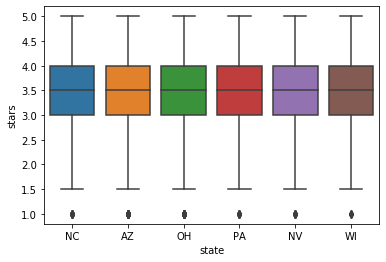

In [83]:
# Does location impact stars?
sns.boxplot(x='state', y='stars', data=bus_state)

All states have the same distribution of star ratings with median star rating of 3.5. However, outlier restaurants are present in all states.

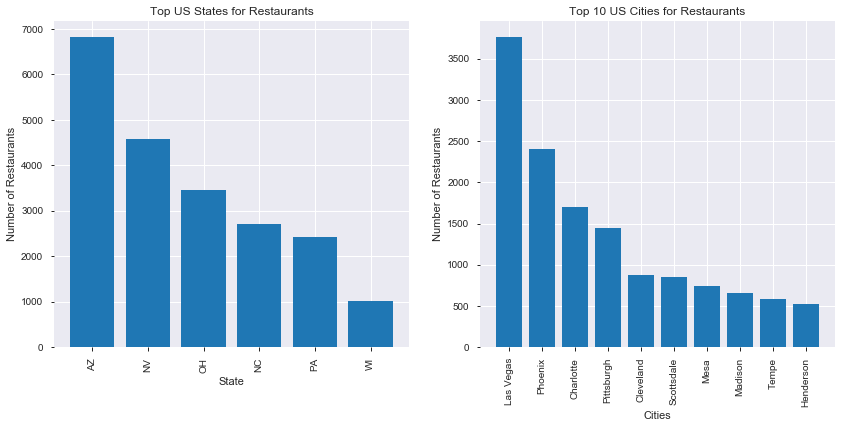

In [276]:
#location plot of restaurants
fig = plt.figure(figsize=(14,6))
#first row, first col
ax1 = plt.subplot2grid((1,2),(0,0))
plt.bar(states,business_state)
plt.xticks(states,rotation = 90)
plt.ylabel("Number of Businesses")
plt.xlabel("State")
plt.title("Top US States for Yelp Businesses")

ax1 = plt.subplot2grid((1,2),(0,1))
plt.bar(cities[:10],business_city[:10])
plt.xticks(cities[:10],rotation = 90)
plt.ylabel("Number of Businesses")
plt.xlabel("Cities")
plt.title("Top 10 US Cities for Yelp Businesses")
plt.show()

Arizona has the maximum number of restaurants followed by Nevada. Arizona may be having multiple cities with high density of restaurants.

In [44]:
#Making dummies out of the states
state1 = pd.get_dummies(bus_state['state'])
state1.head()

,AZ,NC,NV,OH,PA,WI
2,0,1,0,0,0,0
11,1,0,0,0,0,0
13,0,0,0,1,0,0
23,0,0,0,0,1,0
25,0,0,1,0,0,0


In [45]:
# As dummies have n-1 categories, dropping Wisconsin state as all states having 0 value will mean Wisconsin is 1
state1.drop('WI',axis=1,inplace=True)  
state1.head()

,AZ,NC,NV,OH,PA
2,0,1,0,0,0
11,1,0,0,0,0
13,0,0,0,1,0
23,0,0,0,0,1
25,0,0,1,0,0


In [46]:
#Merging state series with data
df = pd.concat([bus_state.drop(['state'],axis=1), state1], axis=1)
df.head()

,business_id,name,city,stars,review_count,categories,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,...,Alcohol_Beer_Wine,Alcohol_Full_Bar,Attire_Casual,Attire_Dressy,Attire_Formal,AZ,NC,NV,OH,PA
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,4.0,170,"Sushi Bars, Restaurants, Japanese",1,0,3,1,...,1,0,1,0,0,0,1,0,0,0
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",0,0,1,1,...,0,0,1,0,0,1,0,0,0,0
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",0,0,1,1,...,0,0,1,0,0,0,0,0,1,0
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,Las Vegas,4.5,184,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",0,0,3,1,...,1,0,1,0,0,0,0,1,0,0


#### Treating Categories

In [92]:
#checking unique categories
df.categories.unique()

array(['Sushi Bars, Restaurants, Japanese',
       'Restaurants, Breakfast & Brunch, Mexican, Tacos, Tex-Mex, Fast Food',
       'Italian, Restaurants, Pizza, Chicken Wings', ...,
       'Bars, American (Traditional), Restaurants, Nightlife, Tex-Mex',
       'Farmers Market, Caterers, Food, Street Vendors, Barbeque, Event Planning & Services, Restaurants',
       'Pizza, Italian, Restaurants, Seafood'], dtype=object)

In [47]:
# Counting number of categories
df['categories_count'] = df['categories'].apply(lambda x: len(x.split(',')))
df.head()

,business_id,name,city,stars,review_count,categories,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,...,Alcohol_Full_Bar,Attire_Casual,Attire_Dressy,Attire_Formal,AZ,NC,NV,OH,PA,categories_count
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,4.0,170,"Sushi Bars, Restaurants, Japanese",1,0,3,1,...,0,1,0,0,0,1,0,0,0,3
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",0,0,1,1,...,0,1,0,0,1,0,0,0,0,6
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",0,0,1,1,...,0,1,0,0,0,0,0,1,0,4
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",0,0,1,1,...,0,0,0,0,0,0,0,0,1,5
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,Las Vegas,4.5,184,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",0,0,3,1,...,0,1,0,0,0,0,1,0,0,6


Text(0.5, 1.0, 'Number of categories vs Number of reviews')

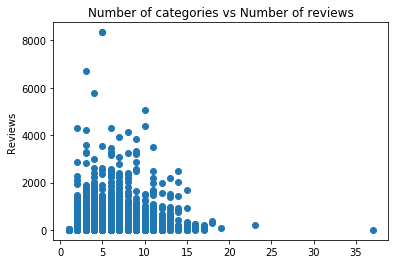

In [47]:
# Scatter plot of number of categories and number of reviews
plt.scatter('categories_count','review_count',data=df)
plt.ylabel("Reviews")
plt.title("Number of categories vs Number of reviews")

In [110]:
df['categories_count'].corr(df['review_count'])

0.14821482265536737

Thus there is no correlation between the number of categories a restaurant is labelled in Yelp and the number of user reviews. Assigning more categories to a restaurant may help in user search but does not impact number of reviews. There are outlier restaurants assigned over 35 categories but still receiving single-digit reviews.

In [48]:
# Split categories using explode
business_explode = df.assign(categories = df.categories.str.split(', ')).explode('categories')
business_explode.head(10)

,business_id,name,city,stars,review_count,categories,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,...,Alcohol_Full_Bar,Attire_Casual,Attire_Dressy,Attire_Formal,AZ,NC,NV,OH,PA,categories_count
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,4.0,170,Sushi Bars,1,0,3,1,...,0,1,0,0,0,1,0,0,0,3
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,4.0,170,Restaurants,1,0,3,1,...,0,1,0,0,0,1,0,0,0,3
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,4.0,170,Japanese,1,0,3,1,...,0,1,0,0,0,1,0,0,0,3
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,3.0,18,Restaurants,0,0,1,1,...,0,1,0,0,1,0,0,0,0,6
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,3.0,18,Breakfast & Brunch,0,0,1,1,...,0,1,0,0,1,0,0,0,0,6
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,3.0,18,Mexican,0,0,1,1,...,0,1,0,0,1,0,0,0,0,6
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,3.0,18,Tacos,0,0,1,1,...,0,1,0,0,1,0,0,0,0,6
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,3.0,18,Tex-Mex,0,0,1,1,...,0,1,0,0,1,0,0,0,0,6
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,3.0,18,Fast Food,0,0,1,1,...,0,1,0,0,1,0,0,0,0,6
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,4.0,16,Italian,0,0,1,1,...,0,1,0,0,0,0,0,1,0,4


In [94]:
# top 50 categories of business - these counts do not add upto 100% as each business_id lists several categories
business_explode.categories.value_counts()[:50]
#Checking categories in chunks of 50 to know the cuisines 

Restaurants                  21016
Food                          5410
Fast Food                     4036
American (Traditional)        3907
Nightlife                     3764
Bars                          3667
Sandwiches                    3566
Pizza                         2935
Burgers                       2637
American (New)                2620
Mexican                       2480
Breakfast & Brunch            2429
Italian                       1745
Salad                         1496
Chinese                       1399
Chicken Wings                 1347
Coffee & Tea                  1235
Event Planning & Services     1232
Seafood                       1160
Sports Bars                    932
Delis                          930
Caterers                       849
Cafes                          821
Japanese                       765
Steakhouses                    696
Asian Fusion                   694
Sushi Bars                     694
Diners                         665
Desserts            

In [95]:
# check unique business categories
cat_count = business_explode.categories.value_counts()
print('Unique categories:',len(cat_count))


Unique categories: 511


In [96]:
labels=business_explode.categories.value_counts().index

In [197]:
#Total Reviews per category
cat_reviews = business_explode.groupby('categories')['review_count'].sum()
cat_reviews.sort_values(ascending=False)[:20]

categories
Restaurants                  2720183
Food                          740832
Nightlife                     717218
Bars                          694104
American (Traditional)        559183
American (New)                555774
Breakfast & Brunch            478890
Sandwiches                    344636
Mexican                       303304
Pizza                         285954
Burgers                       281200
Italian                       262729
Seafood                       252361
Event Planning & Services     226107
Salad                         199439
Japanese                      181930
Steakhouses                   181814
Fast Food                     168761
Sushi Bars                    162795
Asian Fusion                  159306
Name: review_count, dtype: int64

Text(0.5, 1.0, 'Top 10 Popular Categories')

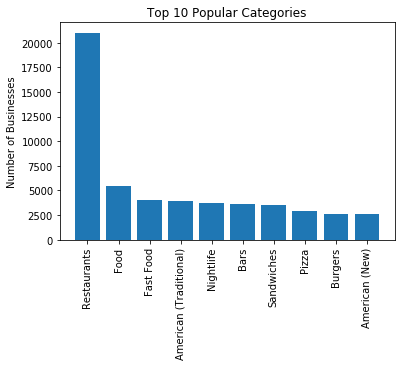

In [99]:
# Top 10 restaurant categories plot
plt.bar(labels[:10],cat_count.values[:10])
plt.xticks(labels[:10],rotation = 90)
plt.ylabel("Number of Businesses")
plt.title("Top 10 Popular Categories")


As above categories seem unrelated, creating super-categories using common knowledge or imputing cuisine served in the restaurant from categories


In [49]:
# creating cuisine type
df['category']=pd.Series()
df.loc[df.categories.str.contains('Sandwiches|Breakfast|Coffee|Cafe|Tea|Desserts|Bakeries'), 'category'] = 'Cafe'
df.loc[df.categories.str.contains('Fast Food|Burgers|Steakhouses|Pizza'), 'category'] = 'Fast_Food'
df.loc[df.categories.str.contains('Mexican'), 'category'] = 'Mexican'
df.loc[df.categories.str.contains('Caribbean'),'category'] = 'Caribbean'
df.loc[df.categories.str.contains('Japanese|Sushi Bars'), 'category'] = 'Japanese'
df.loc[df.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
df.loc[df.categories.str.contains('Chinese'), 'category'] = 'Chinese'
df.loc[df.categories.str.contains('Thai'), 'category'] = 'Thai'
df.loc[df.categories.str.contains('Canadian'), 'category'] = 'Canadian'
df.loc[df.categories.str.contains('Middle Eastern'),'category'] = 'Middle_Eastern'
df.loc[df.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
df.loc[df.categories.str.contains('French'), 'category'] = 'French'
df.loc[df.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
df.loc[df.categories.str.contains('Greek'),'category'] = 'Greek'
df.loc[df.categories.str.contains('Indian'),'category'] = 'Indian'
df.loc[df.categories.str.contains('Korean'),'category'] = 'Korean'
df.loc[df.categories.str.contains('American'),'category'] = 'American'

df.loc[df.categories.str.contains('Taiwanese'),'category'] = 'Taiwanese'
df.loc[df.categories.str.contains('Italian'), 'category'] = 'Italian'
df.loc[df.categories.str.contains('Modern European'), 'category'] = 'Modern_European'

df[:60]


,business_id,name,city,stars,review_count,categories,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,...,Attire_Casual,Attire_Dressy,Attire_Formal,AZ,NC,NV,OH,PA,categories_count,category
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,4.0,170,"Sushi Bars, Restaurants, Japanese",1,0,3,1,...,1,0,0,0,1,0,0,0,3,Japanese
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",0,0,1,1,...,1,0,0,1,0,0,0,0,6,Mexican
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings",0,0,1,1,...,1,0,0,0,0,0,1,0,4,Italian
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",0,0,1,1,...,0,0,0,0,0,0,0,1,5,Fast_Food
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,Las Vegas,4.5,184,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",0,0,3,1,...,1,0,0,0,0,1,0,0,6,Mexican
66,dQj5DLZjeDK3KFysh1SYOQ,Apteka,Pittsburgh,4.5,242,"Nightlife, Bars, Polish, Modern European, Rest...",0,1,3,1,...,1,0,0,0,0,0,0,1,6,Modern_European
73,v-scZMU6jhnmV955RSzGJw,No. 1 Sushi Sushi,Pittsburgh,4.5,106,"Japanese, Sushi Bars, Restaurants",0,1,3,1,...,1,0,0,0,0,0,0,1,3,Japanese
77,KFbUQ-RR2UOV62Ep7WnXHw,Westwood Bar & Grill,West Mifflin,3.0,5,"American (Traditional), Restaurants",1,1,3,1,...,1,0,0,0,0,0,0,1,2,American
78,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,3.5,269,"Chinese, Restaurants",1,1,3,1,...,1,0,0,1,0,0,0,0,2,Chinese
113,7aLkFEBnL1LJmQdcuaovuQ,Ohio Beer Garden,North Olmsted,4.0,8,"Restaurants, Pubs, Bars, Nightlife, American (...",0,0,3,0,...,1,0,0,0,0,0,1,0,6,American


In [58]:
# Checking % of missing category
df['category'].isnull().sum()/len(df) * 100

6.478242619280818

In [52]:
# Drop restaurants with missing food category as missing % is very low
df2 = df.dropna(axis=0)
print('Restaurants remaining out of 21,016 after dropping those with missing food category:',len(df2))

Restaurants remaining out of 21,016 after dropping those with missing food category: 19656


In [53]:
df2.drop('categories',axis=1,inplace=True)

Text(0.5, 1.02, 'Top Food categories in US')

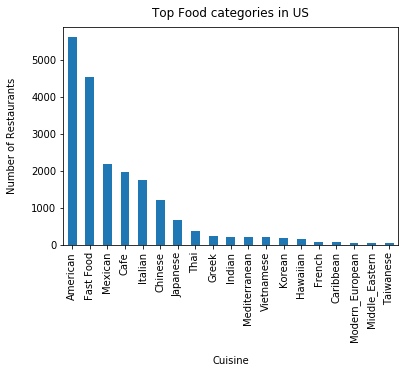

In [151]:
#plot distribution of top imputed cuisines
df2.category.value_counts().plot(kind='bar')
plt.xlabel("Cuisine", labelpad=14)
plt.ylabel("Number of Restaurants", labelpad=14)
plt.title("Top Food categories in US", y=1.02)

Over 5000 US restaurants serve American cuisine

In [67]:
# Top 20 reviewed cusines by city
top=df2.groupby(['city','category'])['review_count'].sum().sort_values(ascending=False)
top.head(20)

city        category 
Las Vegas   American     312614
Phoenix     American     116348
Las Vegas   Fast Food     90832
            Italian       85015
Scottsdale  American      78837
Las Vegas   Cafe          73492
            Japanese      72879
            Mexican       68729
Charlotte   American      63601
Pittsburgh  American      51732
Phoenix     Mexican       48375
            Italian       43668
Las Vegas   Chinese       41977
Phoenix     Fast Food     33358
            Cafe          29169
Las Vegas   French        29148
Tempe       American      27556
Las Vegas   Korean        27221
Henderson   American      26445
Las Vegas   Thai          26146
Name: review_count, dtype: int64

American and Fast Food are the most popular reviewed restaurant cuisine categories.

In [54]:
# making category dummies
code = pd.get_dummies(df2['category'])
code.head()

,American,Cafe,Caribbean,Chinese,Fast_Food,French,Greek,Hawaiian,Indian,Italian,Japanese,Korean,Mediterranean,Mexican,Middle_Eastern,Modern_European,Taiwanese,Thai,Vietnamese
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [55]:
# As dummies have n-1 categories, dropping Taiwanese
code.drop('Taiwanese',axis=1,inplace=True)  
code.head()

,American,Cafe,Caribbean,Chinese,Fast_Food,French,Greek,Hawaiian,Indian,Italian,Japanese,Korean,Mediterranean,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [56]:
# merging back to data
res_data = pd.concat([df2.drop(['city','name'],axis=1), code], axis=1)
res_data.head()

,business_id,stars,review_count,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,RestaurantsPriceRange2,OutdoorSeating,BikeParking,...,Indian,Italian,Japanese,Korean,Mediterranean,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese
2,gnKjwL_1w79qoiV3IC_xQQ,4.0,170,1,0,3,1,3,0,1,...,0,0,1,0,0,0,0,0,0,0
11,1Dfx3zM-rW4n-31KeC8sJg,3.0,18,0,0,1,1,2,0,0,...,0,0,0,0,0,1,0,0,0,0
13,fweCYi8FmbJXHCqLnwuk8w,4.0,16,0,0,1,1,3,0,1,...,0,1,0,0,0,0,0,0,0,0
23,1RHY4K3BD22FK7Cfftn8Mg,4.0,35,0,0,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
25,tstimHoMcYbkSC4eBA1wEg,4.5,184,0,0,3,1,2,0,1,...,0,0,0,0,0,1,0,0,0,0


#### Photos:

In [57]:
# Importing Photos data
photo = pd.read_json(photo_json_path, lines=True)
photo.head()

,caption,photo_id,business_id,label
0,,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,inside
1,,YjxBE88Bf6CmTEF2LP1UNA,Kn23LDd740SBVJ7mum0fwg,inside
2,,1f7izSjM0WjkDRIVbPy1yw,ZkGDCVKSdf8m76cnnalL-A,food
3,,NcSlcDTEEeOaixotOPk-rA,bF8gv7k_rwZtiDLP2ZB04w,inside
4,,5IiIo5UKEW0lWqZ6sWrY_A,50Anorn0DJXFhBr9a9_gHQ,inside


In [569]:
photo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
caption        200000 non-null object
photo_id       200000 non-null object
business_id    200000 non-null object
label          200000 non-null object
dtypes: object(4)
memory usage: 6.1+ MB


In [111]:
photo.caption.value_counts(normalize=True)

                                             0.539250
Interior                                     0.002290
Inside                                       0.001940
Menu                                         0.001605
McDonald's All Day Breakfast Sandwiches      0.001490
                                               ...   
Dynamite Rolls                               0.000005
Negima (chicken thigh & Tokyo scallion)      0.000005
Chef Mio with torch and small decorations    0.000005
Everything bagel flatbread.                  0.000005
Oysters for a mere $3 each                   0.000005
Name: caption, Length: 71513, dtype: float64

Photos has over 50% missing values in caption. So will drop this variable.

In [9]:
photo.business_id.nunique()

30488

In [58]:
# Dropping caption and photo id
photo_df = photo.drop(['caption','photo_id'],axis=1)

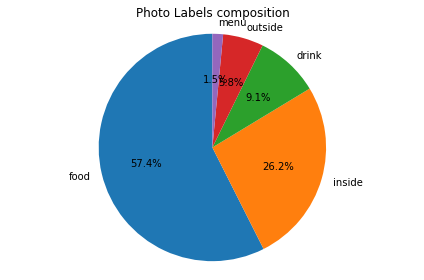

In [12]:
# Pie chart for photo label distribution
plt.pie(
   photo_df['label'].value_counts().values, # plot the value counts
    labels= photo_df['label'].value_counts().index, # add the labels
    startangle=90, # make it easier to read by starting at 90degree angle
    autopct='%1.1f%%', # label percent
    )
plt.title("Photo Labels composition")
# View the plot drop above
plt.axis('equal')
plt.tight_layout()

In [59]:
# Creating dummies of photo label
photo_dum = pd.get_dummies(photo_df['label']).add_prefix('Photo_')
photo_dum

,Photo_drink,Photo_food,Photo_inside,Photo_menu,Photo_outside
0,0,0,1,0,0
1,0,0,1,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
199995,0,0,1,0,0
199996,0,0,1,0,0
199997,0,1,0,0,0
199998,0,0,1,0,0


In [60]:
# As dummies have n-1 categories, dropping photo menu
photo_dum.drop('Photo_menu',axis=1,inplace=True)  
photo_dum.head()

,Photo_drink,Photo_food,Photo_inside,Photo_outside
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,1,0


In [61]:
# joining back to photo data
photo1 = pd.concat([photo_df.drop('label',axis=1), photo_dum], axis=1)
photo1.head()

,business_id,Photo_drink,Photo_food,Photo_inside,Photo_outside
0,rcaPajgKOJC2vo_l3xa42A,0,0,1,0
1,Kn23LDd740SBVJ7mum0fwg,0,0,1,0
2,ZkGDCVKSdf8m76cnnalL-A,0,1,0,0
3,bF8gv7k_rwZtiDLP2ZB04w,0,0,1,0
4,50Anorn0DJXFhBr9a9_gHQ,0,0,1,0


In [119]:
#checking if photo data has distinct business ids

photo1.business_id.is_unique

False

There are multiple photo labels per business

In [62]:
# Getting list of photo columns
photo_cols = list(photo1.columns[1:])

In [63]:
#Adding photo counts for each business
photo1=photo1.groupby('business_id')[photo_cols].sum()
photo1.head()
# The data shows number of photos by label for each business id

,Photo_drink,Photo_food,Photo_inside,Photo_outside
business_id,,,,
--6MefnULPED_I942VcFNA,0.0,3.0,0.0,0.0
--9e1ONYQuAa-CB_Rrw7Tw,5.0,59.0,7.0,2.0
--DaPTJW3-tB1vP-PfdTEg,0.0,0.0,0.0,1.0
--FBCX-N37CMYDfs790Bnw,0.0,1.0,0.0,0.0
--KCl2FvVQpvjzmZSPyviA,0.0,2.0,0.0,0.0


In [64]:
# Merging with restaurants data on business_id and replacing missing photos for businesses by 0
resdata2=pd.merge(res_data,photo1, on='business_id', how='left')
resdata2.fillna('0', inplace=True)
resdata2.head()

,business_id,stars,review_count,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,RestaurantsPriceRange2,OutdoorSeating,BikeParking,...,Mediterranean,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese,Photo_drink,Photo_food,Photo_inside,Photo_outside
0,gnKjwL_1w79qoiV3IC_xQQ,4.0,170,1,0,3,1,3,0,1,...,0,0,0,0,0,0,0,6,2,0
1,1Dfx3zM-rW4n-31KeC8sJg,3.0,18,0,0,1,1,2,0,0,...,0,1,0,0,0,0,0,0,0,0
2,fweCYi8FmbJXHCqLnwuk8w,4.0,16,0,0,1,1,3,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1RHY4K3BD22FK7Cfftn8Mg,4.0,35,0,0,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tstimHoMcYbkSC4eBA1wEg,4.5,184,0,0,3,1,2,0,1,...,0,1,0,0,0,0,0,2,0,0


In [119]:
# Checking data types of newly added photo columns 
resdata2[photo_cols].dtypes

Photo_drink      object
Photo_food       object
Photo_inside     object
Photo_outside    object
dtype: object

In [65]:
#Dropping Business id and category as it will not have any meaning for analysis
res_photo = resdata2.drop(['business_id','category'],axis=1)
res_photo.head()

,stars,review_count,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,RestaurantsPriceRange2,OutdoorSeating,BikeParking,HasTV,...,Mediterranean,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese,Photo_drink,Photo_food,Photo_inside,Photo_outside
0,4.0,170,1,0,3,1,3,0,1,1,...,0,0,0,0,0,0,0,6,2,0
1,3.0,18,0,0,1,1,2,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,4.0,16,0,0,1,1,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,35,0,0,1,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.5,184,0,0,3,1,2,0,1,1,...,0,1,0,0,0,0,0,2,0,0


In [73]:
#Checking final data length  
print('Final Data for restaurants:',len(res_photo))
# Have photo attribute for the 21,016 restaurants

Final Data for restaurants: 19656


In [66]:
# Converting photo column data type to integers  
res_photo[photo_cols] = res_photo[photo_cols].astype(int)
res_photo.head()

,stars,review_count,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,RestaurantsPriceRange2,OutdoorSeating,BikeParking,HasTV,...,Mediterranean,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese,Photo_drink,Photo_food,Photo_inside,Photo_outside
0,4.0,170,1,0,3,1,3,0,1,1,...,0,0,0,0,0,0,0,6,2,0
1,3.0,18,0,0,1,1,2,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,4.0,16,0,0,1,1,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,35,0,0,1,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.5,184,0,0,3,1,2,0,1,1,...,0,1,0,0,0,0,0,2,0,0


In [67]:
# Binning stars
starscat = pd.cut(res_photo.stars, 2)

In [68]:
for x in starscat.unique():
    print(x)

(3.0, 5.0]
(0.996, 3.0]


In [69]:
# Converting Stars to binary response - 
# 0 for star rating between 1 - 3 or Low rated restaurants
# 1 for star rating between 3.5 - 5  or High rated restaurants
res_photo['starscat'] = pd.cut(res_photo.stars, 2, labels=["0", "1"])

In [70]:
res_photo.starscat.value_counts(normalize=True)
# 1 is the majority class having star ratings greater than equal to 3.5. The response class is  imbalanced.

1    0.636752
0    0.363248
Name: starscat, dtype: float64

In [71]:
rp_cols = list(res_photo.columns)
rp_cols

['stars',
 'review_count',
 'RestaurantsReservations',
 'Caters',
 'NoiseLevel',
 'RestaurantsTakeOut',
 'RestaurantsPriceRange2',
 'OutdoorSeating',
 'BikeParking',
 'HasTV',
 'GoodForKids',
 'RestaurantsGoodForGroups',
 'RestaurantsDelivery',
 'GoodForDessert',
 'GoodForLatenight',
 'GoodForLunch',
 'GoodForDinner',
 'GoodForBrunch',
 'GoodForBreakfast',
 'ParkingGarage',
 'ParkingStreet',
 'ParkingValidated',
 'ParkingLot',
 'ParkingValet',
 'WiFi_Free',
 'WiFi_Paid',
 'Alcohol_Beer_Wine',
 'Alcohol_Full_Bar',
 'Attire_Casual',
 'Attire_Dressy',
 'Attire_Formal',
 'AZ',
 'NC',
 'NV',
 'OH',
 'PA',
 'categories_count',
 'American',
 'Cafe',
 'Caribbean',
 'Chinese',
 'Fast_Food',
 'French',
 'Greek',
 'Hawaiian',
 'Indian',
 'Italian',
 'Japanese',
 'Korean',
 'Mediterranean',
 'Mexican',
 'Middle_Eastern',
 'Modern_European',
 'Thai',
 'Vietnamese',
 'Photo_drink',
 'Photo_food',
 'Photo_inside',
 'Photo_outside',
 'starscat']

In [72]:
#Converting object and uint columns to int
res_photo[rp_cols] = res_photo[rp_cols].astype(int)
#res_photo = res_photo.drop('category',axis=1)
res_photo

,stars,review_count,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,RestaurantsPriceRange2,OutdoorSeating,BikeParking,HasTV,...,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese,Photo_drink,Photo_food,Photo_inside,Photo_outside,starscat
0,4,170,1,0,3,1,3,0,1,1,...,0,0,0,0,0,0,6,2,0,1
1,3,18,0,0,1,1,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,4,16,0,0,1,1,3,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,4,35,0,0,1,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,184,0,0,3,1,2,0,1,1,...,1,0,0,0,0,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19651,4,16,0,1,3,1,2,1,1,0,...,0,0,0,0,0,0,0,0,0,1
19652,2,39,0,0,4,1,3,0,0,1,...,0,0,0,0,0,0,1,0,0,0
19653,4,142,0,1,3,1,3,1,1,0,...,0,0,0,0,0,1,4,4,0,1
19654,4,22,0,0,4,1,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [73]:
# Dropping stars and using stars category
res_photo_sc = res_photo.drop('stars',axis=1)

In [129]:
res_photo_sc

,review_count,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,RestaurantsPriceRange2,OutdoorSeating,BikeParking,HasTV,GoodForKids,...,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese,Photo_drink,Photo_food,Photo_inside,Photo_outside,starscat
0,170,1,0,3,1,3,0,1,1,1,...,0,0,0,0,0,0,6,2,0,1
1,18,0,0,1,1,2,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,16,0,0,1,1,3,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,35,0,0,1,1,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,184,0,0,3,1,2,0,1,1,1,...,1,0,0,0,0,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19651,16,0,1,3,1,2,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
19652,39,0,0,4,1,3,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
19653,142,0,1,3,1,3,1,1,0,1,...,0,0,0,0,0,1,4,4,0,1
19654,22,0,0,4,1,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [244]:
cor= res_photo_sc.drop('starscat',axis=1).corr()
cor

,review_count,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,RestaurantsPriceRange2,OutdoorSeating,BikeParking,HasTV,GoodForKids,...,Mediterranean,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese,Photo_drink,Photo_food,Photo_inside,Photo_outside
review_count,1.000000,0.210917,0.073141,0.169077,-0.091750,0.267603,0.122091,0.081176,0.124339,-0.055878,...,0.002543,-0.024463,-0.011102,0.004808,0.035200,0.029728,0.465378,0.591711,0.598161,0.462224
RestaurantsReservations,0.210917,1.000000,0.154460,0.082239,-0.133909,0.474966,0.127998,0.051292,0.288695,-0.180962,...,0.030866,-0.073588,0.005444,0.038300,0.097111,0.032374,0.188852,0.117290,0.157384,0.117457
Caters,0.073141,0.154460,1.000000,0.127396,0.116209,0.046106,0.189284,0.212666,0.110366,0.113499,...,0.066795,0.022084,0.024699,0.020492,0.040855,-0.014519,0.010516,0.020208,0.008606,0.025648
NoiseLevel,0.169077,0.082239,0.127396,1.000000,0.017631,0.155109,0.147264,0.189077,0.197111,-0.010716,...,-0.016355,0.018205,-0.006660,-0.001973,-0.028164,-0.006462,0.086384,0.071707,0.086034,0.076257
RestaurantsTakeOut,-0.091750,-0.133909,0.116209,0.017631,1.000000,-0.217809,0.007721,0.089797,0.008867,0.285815,...,0.003539,0.045950,-0.009126,-0.024036,0.026529,0.017775,-0.129258,-0.109078,-0.168636,-0.094792
RestaurantsPriceRange2,0.267603,0.474966,0.046106,0.155109,-0.217809,1.000000,0.128026,0.002474,0.246108,-0.228642,...,0.017107,-0.125286,0.002092,0.022706,0.056285,-0.018773,0.231912,0.174110,0.226712,0.152428
OutdoorSeating,0.122091,0.127998,0.189284,0.147264,0.007721,0.128026,1.000000,0.248359,0.145574,-0.072893,...,0.026737,0.024894,0.000249,0.019372,-0.049976,-0.037142,0.100486,0.020067,0.058091,0.135512
BikeParking,0.081176,0.051292,0.212666,0.189077,0.089797,0.002474,0.248359,1.000000,0.131249,0.052938,...,0.022272,0.022603,0.007247,0.013921,0.029732,0.005936,0.013787,-0.004578,-0.016735,0.017328
HasTV,0.124339,0.288695,0.110366,0.197111,0.008867,0.246108,0.145574,0.131249,1.000000,-0.124199,...,-0.009621,0.007560,-0.011757,-0.005507,-0.005750,0.034930,0.087709,0.026518,0.054217,0.054075
GoodForKids,-0.055878,-0.180962,0.113499,-0.010716,0.285815,-0.228642,-0.072893,0.052938,-0.124199,1.000000,...,0.011907,0.096897,0.000598,-0.031203,0.044741,0.031180,-0.123612,-0.026450,-0.105885,-0.053694


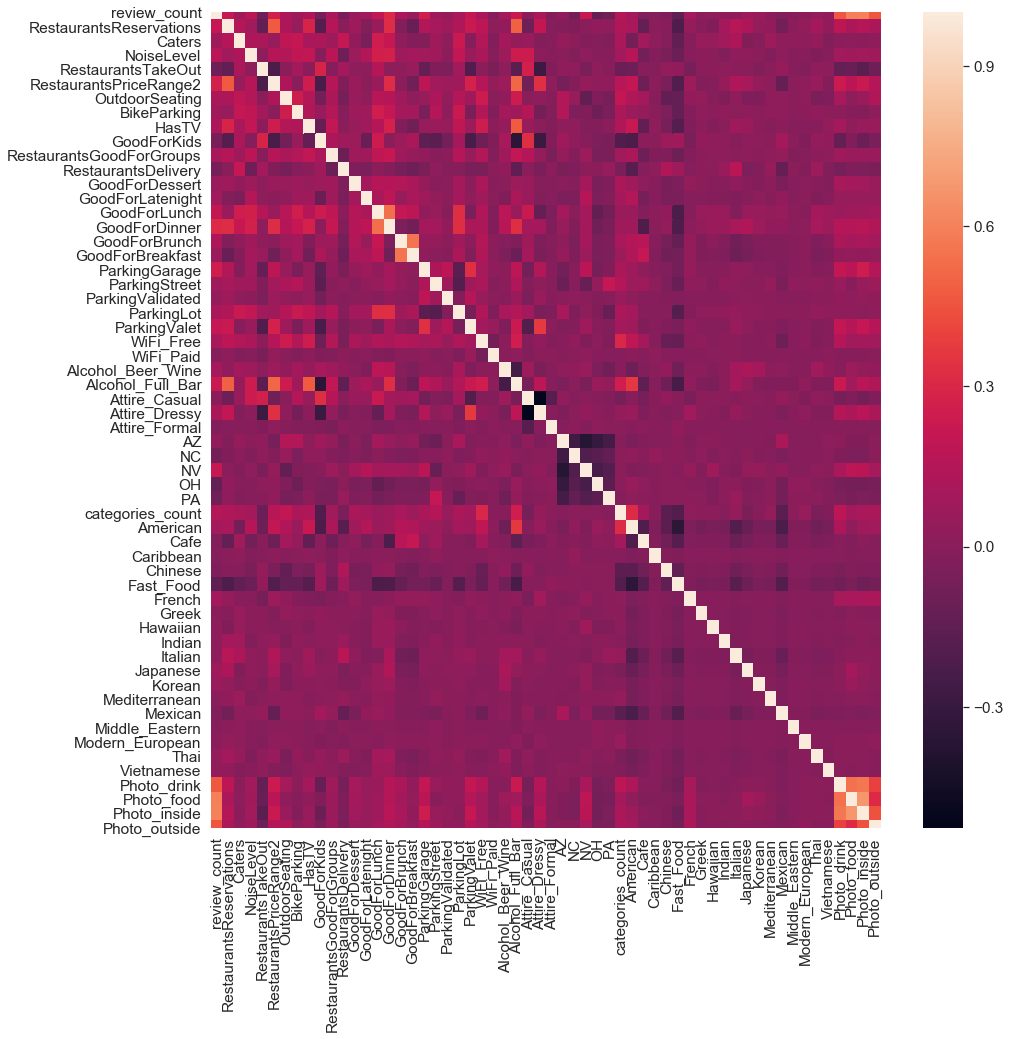

In [246]:
# Plotting correlation heatmap
fig = plt.figure(figsize=(15,15))
sns.heatmap(cor, 
xticklabels=cor.columns.values,
yticklabels=cor.columns.values)
vmin=-1, # color scale minimum value
vmax=1, # color scale maximum value
center=0, # switch colors at 0 to indicate positive-negative relationships
cmap= sns.diverging_palette(20, 220, n=200), 
square=True 
# axis aspect is set to equal

A lot of features are correlated with each other. Eg. Alcohol beer and wine and Alcohol full bar, Attire Dressy and Attire Casual are negatively correlated pairs. Similarly Good for Lunch and Good for Dinner, Good For Breakfast and Good for Brunch are positively correlated pairs. Also, photo labels are also strongly positively correlated among themselves and with reviews.

In [247]:
# Checking correlation values
d = cor.unstack()
so = d.sort_values(kind="quicksort")
so.head(65)

Attire_Dressy  Attire_Casual      -0.526451
Attire_Casual  Attire_Dressy      -0.526451
NV             AZ                 -0.368320
AZ             NV                 -0.368320
GoodForKids    Alcohol_Full_Bar   -0.351510
                                     ...   
Fast_Food      ParkingLot         -0.191555
ParkingLot     Fast_Food          -0.191555
ParkingStreet  ParkingLot         -0.189939
ParkingLot     ParkingStreet      -0.189939
PA             NV                 -0.188326
Length: 65, dtype: float64

This shows presence of strong correlation but nothing alarmingly high (> 0.7) indicating no presence of multicollinearity.

#### Features and Target

In [74]:
features = res_photo_sc.columns[0:-1]

data = res_photo_sc[features]
X =data

y = res_photo_sc.starscat

X.head()


,review_count,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,RestaurantsPriceRange2,OutdoorSeating,BikeParking,HasTV,GoodForKids,...,Mediterranean,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese,Photo_drink,Photo_food,Photo_inside,Photo_outside
0,170,1,0,3,1,3,0,1,1,1,...,0,0,0,0,0,0,0,6,2,0
1,18,0,0,1,1,2,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,16,0,0,1,1,3,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,35,0,0,1,1,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,184,0,0,3,1,2,0,1,1,1,...,0,1,0,0,0,0,0,2,0,0


##### VIF

In [76]:
# checking multicollinearity by vif - it estimates how much the variance of a coefficient is “inflated” because of linear dependence with other predictors.

#VIF calculated for each predictor by doing a linear regression of that predictor on all the other predictors, and then obtaining the R2 from that regression. 
#VIF = 1/(1-R2)

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [145]:
# A vif = 1 indicates that there is no correlation between this independent variable and any others. 
# vif > 10 represent critical levels of multicollinearity where the coefficients are poorly estimated, and the p-values are questionable.

vif

,VIF Factor,features
0,2.762258,review_count
1,2.293743,RestaurantsReservations
2,2.311076,Caters
3,12.702344,NoiseLevel
4,25.958825,RestaurantsTakeOut
5,31.762935,RestaurantsPriceRange2
6,2.169321,OutdoorSeating
7,3.902868,BikeParking
8,2.946575,HasTV
9,10.106947,GoodForKids


The 4 dummy variables - Attire_Casual, NoiseLevel, RestaurantsTakeOut, Fast_Food and American have high vif > 10 and RestaurantsPriceRange2 also has vif > 10.

In [102]:
# Dropping RestaurantsPriceRange2 as it has the highest vif. For other dummy variables, VIF can be high if reference category is small.
# Also standardization will further reduce VIF
X1=X.drop(['RestaurantsPriceRange2'],axis=1)

In [138]:
# final check of features
X.describe()

,review_count,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,RestaurantsPriceRange2,OutdoorSeating,BikeParking,HasTV,GoodForKids,...,Mediterranean,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese,Photo_drink,Photo_food,Photo_inside,Photo_outside
count,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,...,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000,19656.000000
mean,127.999237,0.269790,0.431013,2.631563,0.953958,2.506003,0.401760,0.675366,0.503053,0.846663,...,0.010480,0.111009,0.002391,0.002391,0.018468,0.010429,0.500153,3.217745,1.378103,0.320716
std,255.673473,0.443862,0.495231,0.889001,0.209581,0.606389,0.490266,0.468250,0.500003,0.360322,...,0.101838,0.314152,0.048842,0.048842,0.134638,0.101593,1.784868,9.554184,5.261273,1.213261
min,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,0.000000,0.000000,3.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,137.000000,1.000000,1.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000
max,8348.000000,1.000000,1.000000,5.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,55.000000,590.000000,327.000000,61.000000


Reviews and Photos have outliers and are skewed.

### Train test split data

In [110]:

from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X1,y, # input x=features, y=targets
                                                test_size = 0.3) # set aside 30% for testing

print (xTrain.shape)
print (xTest.shape)

(13759, 55)
(5897, 55)


In [162]:
yTrain.value_counts(normalize = True)

1    0.638491
0    0.361509
Name: starscat, dtype: float64

Thus majority class baseline is 0.64 which the model needs to beat

In [105]:
# SMOTE for treating imbalanced classes
#!pip install imblearn 
#pip install -U imbalanced-learn
#conda install -c glemaitre imbalanced-learn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE


# Resample the minority class. 
#sm = SMOTE(sampling_strategy='minority', random_state=7)
sm = SMOTE(random_state=12)
xtrain_res, ytrain_res = sm.fit_sample(xTrain, yTrain)

#By oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. So these results should be generalizable. 

The model error and accuracy did not improve on over-sampling and the data was not over-sampled.

#### Standardizing features

In [163]:
# To reduce skewness and impact of outliers, using power transformation, default is Box Cox transformation
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
# apply the transformation to the training data
X_train_pt = pt.fit_transform(xTrain)

# apply the transformation to the testing data
X_test_pt = pt.transform(xTest) # but we only transform our testing data with already fit scaler

# convert resulting array back to dataframe
Xtest_pt = pd.DataFrame(X_test_pt,
                     columns=xTrain.columns)


Xtrain_pt = pd.DataFrame(X_train_pt,
                     columns=xTrain.columns)
Xtest_pt.head()

,review_count,RestaurantsReservations,Caters,NoiseLevel,RestaurantsTakeOut,OutdoorSeating,BikeParking,HasTV,GoodForKids,RestaurantsGoodForGroups,...,Mediterranean,Mexican,Middle_Eastern,Modern_European,Thai,Vietnamese,Photo_drink,Photo_food,Photo_inside,Photo_outside
0,-1.524112,-0.608956,-0.873798,0.383979,0.225715,-0.819021,0.692777,0.995721,0.430113,-2.595018,...,-0.102481,-0.351367,-0.0505,-0.051927,-0.138511,-0.103203,-0.492692,-0.940324,-0.736302,-0.47637
1,0.848853,1.642154,1.144430,0.383979,0.225715,1.220970,0.692777,0.995721,-2.324972,0.385354,...,-0.102481,-0.351367,-0.0505,-0.051927,-0.138511,-0.103203,-0.492692,-0.940324,0.956519,-0.47637
2,0.669925,1.642154,1.144430,0.383979,0.225715,1.220970,0.692777,0.995721,0.430113,0.385354,...,-0.102481,-0.351367,-0.0505,-0.051927,-0.138511,-0.103203,2.095741,0.900461,1.719978,-0.47637
3,-0.608328,-0.608956,1.144430,0.383979,0.225715,-0.819021,-1.443466,0.995721,0.430113,0.385354,...,-0.102481,2.846027,-0.0505,-0.051927,-0.138511,-0.103203,-0.492692,0.900461,0.956519,-0.47637
4,1.015777,1.642154,-0.873798,3.076553,0.225715,-0.819021,0.692777,0.995721,-2.324972,0.385354,...,-0.102481,-0.351367,-0.0505,-0.051927,-0.138511,-0.103203,-0.492692,1.493617,1.785564,-0.47637


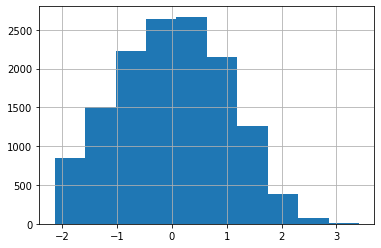

In [164]:
Xtrain_pt.review_count.hist()

The transformation helps reviews distribution to become like Gaussian.

#### Logistic Regression to predict star class 0 and 1

In [169]:

from sklearn.preprocessing import scale
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


logreg = LogisticRegression()
logreg.fit(Xtrain_pt,yTrain)
y_pred = logreg.predict(Xtest_pt)

In [171]:
print('Mean Absolute Error:', metrics.mean_absolute_error(yTest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yTest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yTest, y_pred)))


Mean Absolute Error: 0.2533491605901306
Mean Squared Error: 0.2533491605901306
Root Mean Squared Error: 0.5033380182244637


As data obtained after SMOTE technique increased error (MAE) and did not improve classification rates, the original imbalanced data was used. 

In [172]:
#Evaluating model results
from sklearn.metrics import classification_report
print(classification_report(yTest,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.58      0.63      2166
           1       0.78      0.84      0.81      3731

    accuracy                           0.75      5897
   macro avg       0.73      0.71      0.72      5897
weighted avg       0.74      0.75      0.74      5897



Logistic Regression model results -<br>
Accuracy = 0.75<br>
Precision = 0.78<br>
Recall = 0.84

In [136]:
# Confusion matrix
clf_matrix = metrics.confusion_matrix(yTest, y_pred)
clf_matrix

array([[1181,  909],
       [ 605, 3202]], dtype=int64)

Text(0.5, 15.0, 'Predicted label')

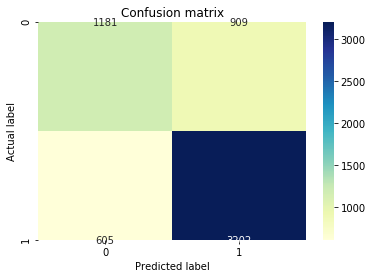

In [137]:
# Heatmap of Confusion matrix
class_names=[0,1] # name  of classes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(clf_matrix), annot=True, cmap="YlGnBu" ,fmt='d')
#ax.xaxis.set_label_position("top")

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

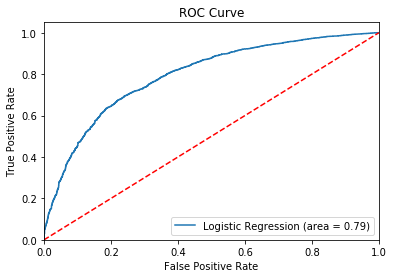

In [138]:
# ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_pred_proba = logreg.predict_proba(Xtest_pt)[::,1] 

fpr, tpr, thresholds = metrics.roc_curve(yTest, y_pred_proba) 
auc = metrics.roc_auc_score(yTest, y_pred_proba) 

plt.plot(fpr,tpr,label="Logistic Regression (area = %0.2f)" %auc ) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4) 
plt.show() 


Logistic: f1=0.809 auc=0.865


(0, 1)

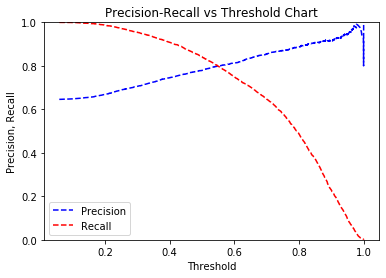

In [139]:
# Precision recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(yTest, y_pred_proba) 
   #retrieve probability of being 1(in second column of probs_y)
auc = metrics.auc(recall, precision)
f1 = metrics.f1_score(yTest, y_pred)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (f1, auc))

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

The logistic regression model has an accuracy of 75%, meaning that it is accurately able to predict the classification 75% of the time
The model has a precision of 78%, meaning that out of all the positive classes the model has predicted correctly, 78% are actually positive.
The model has a recall of 84%, meaning that out of all the positive classes, the model predicted 84% correctly.

The AUC (Area Under Curve) value tells about the model's capability in distinguishing between classes. The higher the AUC, the better the model. With an AUC of 0.79, the logistic regression model is an OK model for this data.
  
Next, the more powerful non parametric classification algorithm random forest was run to compare performance against the logistic regression model. 


#### Random Forest

In [174]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 500 decision trees
rf = RandomForestClassifier(n_estimators = 500, random_state = 0)

# Train the model on training data
rf.fit(Xtrain_pt,yTrain)


y_pred = rf.predict(Xtest_pt)

# Probabilities for each class
rf_probs = rf.predict_proba(Xtest_pt)[:, 1]

print('Mean Absolute Error:', metrics.mean_absolute_error(yTest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yTest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yTest, y_pred)))

Mean Absolute Error: 0.22740376462608106
Mean Squared Error: 0.22740376462608106
Root Mean Squared Error: 0.47686870795438135


In [175]:
#Evaluating model results
print(classification_report(yTest,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.57      0.65      2166
           1       0.78      0.89      0.83      3731

    accuracy                           0.77      5897
   macro avg       0.77      0.73      0.74      5897
weighted avg       0.77      0.77      0.76      5897



Random Forest model results -<br>
Accuracy = 0.77<br>
Precision = 0.78<br>
Recall = 0.89<br>
F1- score = 0.83 

In [176]:
# Confusion matrix
clf_rf_matrix = metrics.confusion_matrix(yTest, y_pred)
clf_rf_matrix

array([[1236,  930],
       [ 411, 3320]], dtype=int64)

Text(0.5, 15.0, 'Predicted label')

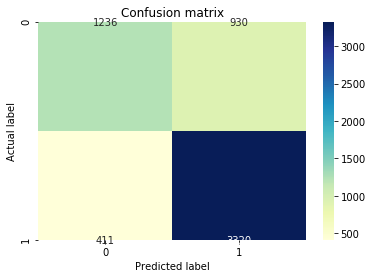

In [177]:
# Heatmap of Confusion matrix
# confusion matrix is useful for giving false positives and false negatives

sns.heatmap(pd.DataFrame(clf_rf_matrix), annot=True, cmap="YlGnBu" ,fmt='d')
#ax.xaxis.set_label_position("top")

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

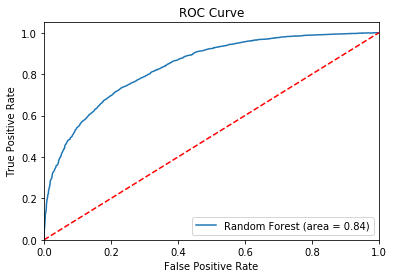

In [178]:
# ROC curve

fpr, tpr, thresholds = metrics.roc_curve(yTest, rf_probs) 
auc = metrics.roc_auc_score(yTest, rf_probs) 

plt.plot(fpr,tpr,label="Random Forest (area = %0.2f)" %auc ) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4) 
plt.show() 

As this is an imbalanced classification problem, accuracy is not an appropriate metric. ROC AUC and Precision-Recall will be used as evaluation metrics.

Random Forest is definitely an improvement over the Logistic Regression Model. <br>
MAE reduces to 23%<br>
ROC AUC increases to 0.84<br>
Accuracy increases to 77%<br>
Recall increases to 89%<br>
Precision remains unchanged at 78%



Text(0.5, 1.0, 'Precision-Recall curve')

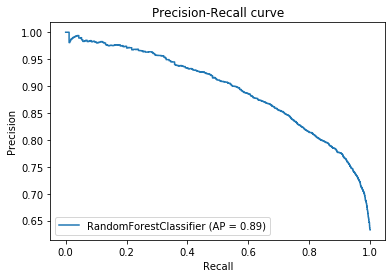

In [179]:
# precision recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(yTest, rf_probs)
disp = plot_precision_recall_curve(rf, Xtest_pt, yTest)
disp.ax_.set_title('Precision-Recall curve')

Average precision or area under precision recall curve is 0.89. It is the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

##### Get feature importance from Random Forest

In [180]:
# The feature importances in a random forest indicate the sum of the reduction in Gini Impurity over all the nodes that are split on that feature.
feature_imp = pd.Series(rf.feature_importances_,index=Xtrain_pt.columns).sort_values(ascending=False)
feature_imp

review_count                0.174634
categories_count            0.074425
Photo_food                  0.063722
NoiseLevel                  0.048881
Photo_inside                0.043250
Fast_Food                   0.032324
GoodForDinner               0.027994
Caters                      0.026041
OutdoorSeating              0.024419
HasTV                       0.023540
GoodForLunch                0.022953
BikeParking                 0.022769
WiFi_Free                   0.022411
ParkingLot                  0.021735
RestaurantsReservations     0.020871
Photo_drink                 0.019708
RestaurantsDelivery         0.019407
AZ                          0.018494
Photo_outside               0.018406
ParkingStreet               0.018039
NV                          0.016496
American                    0.015530
OH                          0.015524
Alcohol_Full_Bar            0.015218
RestaurantsGoodForGroups    0.015147
GoodForKids                 0.014267
PA                          0.013596
N

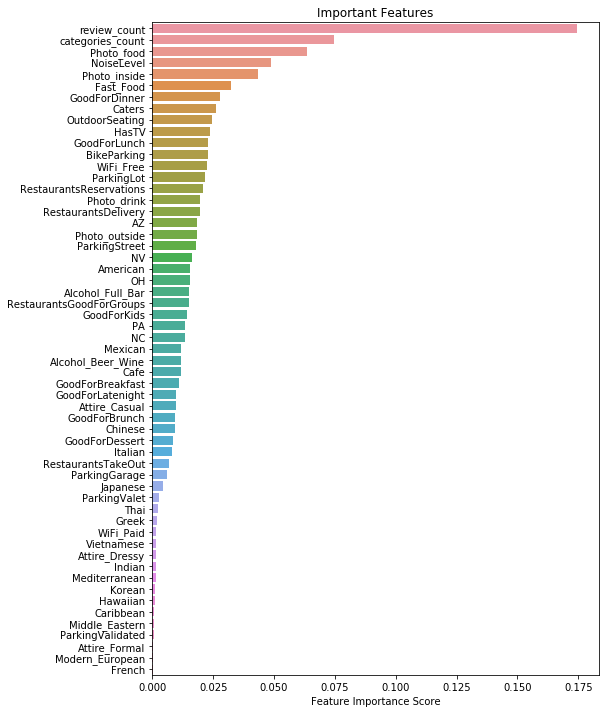

In [181]:
# Visualizing feature importance
fig = plt.figure(figsize=(8,12))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.title("Important Features")
plt.show()

Optimal number of features : 42


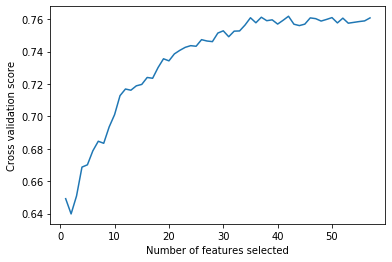

In [184]:
# Choosing best features
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


# Create the RFE object and compute a cross-validated score.
# The f1 score is proportional to the number of correct
# classifications
rfecv = RFECV(RandomForestClassifier(random_state=0), cv=StratifiedKFold(5), 
              scoring='f1_weighted')
rfecv.fit(Xtrain_pt,yTrain)

print("Optimal number of features : %d" % rfecv.n_features_)


# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

So optimal features selected are 42 scored according to F1 - score which is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases in imbalanced classes than accuracy. Harmonic Mean penalizes the extreme values.

In [185]:
cols = Xtrain_pt.columns[rfecv.support_]
acc = accuracy_score(yTest, rfecv.estimator_.predict(Xtest_pt[cols]))

In [186]:
print('Test Accuracy {}'.format(acc))
print("Selected Features: %s" % (rfecv.support_))
print("Feature Ranking: %s" % (rfecv.ranking_))
print("Feature Importances:", rfecv.estimator_.feature_importances_)
print("Features: ",Xtrain_pt.columns[rfecv.support_])

Test Accuracy 0.7724266576225199
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True False
  True  True  True False False  True  True  True  True  True  True  True
  True False  True  True False False False False  True  True False False
  True False False False False  True  True  True  True]
Feature Ranking: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  1  1  1  4
  1  1  1  7 14  1  1  1  1  1  1  1  1 11  1  1 15  3 10  6  1  1  9  8
  1 13 16  2  5  1  1  1  1]
Feature Importances: [0.18533199 0.0214744  0.02561565 0.04904952 0.00680509 0.02444379
 0.02252218 0.0236747  0.014759   0.01528598 0.02026263 0.00840696
 0.00981513 0.02151841 0.02544565 0.00914007 0.01111991 0.00615606
 0.01678365 0.02221866 0.00274052 0.02269367 0.01177992 0.01552238
 0.0102955  0.01902353 0.01318186 0.01683545 0.01595803 0.01403778
 0.07568413 0.01563457 0.01111724 0.00933806 0.03602

The accuracy remains same after RFE = 0.77. Thus maximum accuracy is achieved with these 42 features. 

In [187]:
feature_imp1= pd.Series(rfecv.estimator_.feature_importances_,index=Xtrain_pt.columns[rfecv.support_]).sort_values(ascending=False)
feature_imp1

review_count                0.185332
categories_count            0.075684
Photo_food                  0.064269
NoiseLevel                  0.049050
Photo_inside                0.044521
Fast_Food                   0.036025
Caters                      0.025616
GoodForDinner               0.025446
OutdoorSeating              0.024444
HasTV                       0.023675
WiFi_Free                   0.022694
BikeParking                 0.022522
ParkingLot                  0.022219
GoodForLunch                0.021518
RestaurantsReservations     0.021474
RestaurantsDelivery         0.020263
Photo_drink                 0.019230
AZ                          0.019024
Photo_outside               0.018022
NV                          0.016835
ParkingStreet               0.016784
OH                          0.015958
American                    0.015635
Alcohol_Full_Bar            0.015522
RestaurantsGoodForGroups    0.015286
GoodForKids                 0.014759
PA                          0.014038
N

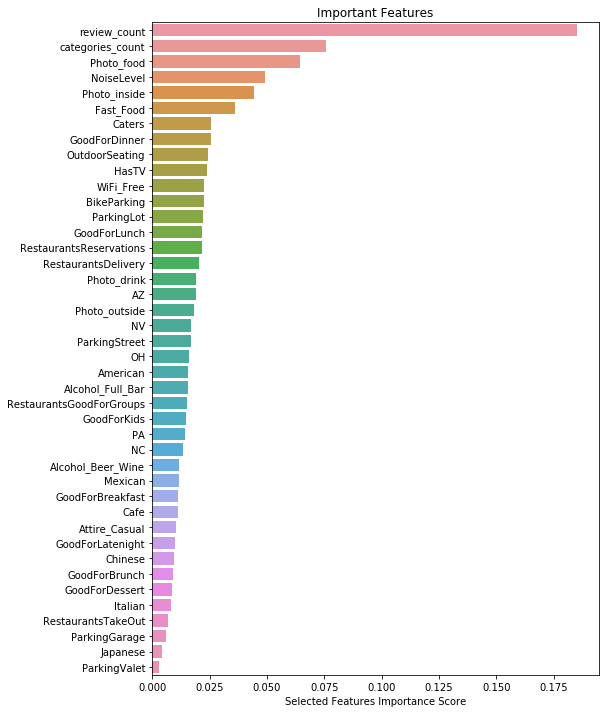

In [188]:
# Visualizing final selectedfeatures ranked by importance

fig = plt.figure(figsize=(8,12))
sns.barplot(x=feature_imp1 , y=feature_imp1.index)
# Add labels to your graph
plt.xlabel('Selected Features Importance Score')
plt.title("Important Features")
plt.show()

Feature selection is simple and straightforward and gives the top features that should be selected to attain the best target prediction.
Disadvantage of using Random Forests for feature selection is that it gives preference to features with high cardinality and that correlated features are given equal or similar importance.

Thus the number of reviews, number of categories listed for a restaurant and the number of food photos are the top predictors of star rating class. 